# PROCAN Connectome and ML: Data structure and questions for analysis
## Exploratory Data Analysis
* Catherine Lebel: Advisor (neuroimaging)
* Paul Metzak: Functional imaging
* Mohammed Shakeel: Structural imaging
* Dr. Roberto Souza: Machine learning 
* Mike Lasby: Machine learning 

Last Updated: 2021-07-11<br>
By: Mike Lasby


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
# from google.colab import drive
import os
import h5py
import re
import umap.umap_ as umap
from sklearn.cluster import DBSCAN
from procan_connectome.config import PLOT_PATH, DATA_PATH

In [3]:
ROOT_PLOT = PLOT_PATH
ROOT_RESULTS = DATA_PATH

In [ ]:
"""Structural connectivity

Group folders: represent each of the 5 groups of interest:
HC 
Stage_0
Stage_1a
Stage_1b
Transition

Sub-folders in each group:
ID: contains participant ID in same order as all remaining files in the folder 
Site_age: contains covariates site and age (in that order)
Global_metrics: contains global metrics
Modular_interactions: contains modular interactions
Nodal_metrics: contains nodal metrics. There are 90 columns in each of these files. Each column represents one AAL region. 
See corresponding names of region in <AAL_Label_Names.txt> (please ignore leading 1's)

Variables to use:
Global_metrics: 
	Connectome density: Represents density of the entire connectome
	Connectome Intensity: Represents intensity of the entire connectome
	Assortativity: standardized value only <rzscore.txt>
	Hierarchy: standardized value only <bzscore.txt>
	Network efficiency: 
		Global efficiency <Eg.txt>
		Local efficiency <Eloc.txt>
	SmallWorld: 
		Clustering coefficient <Cp.txt>
		Gamma <Gamma.txt>
		Lambda <Lambda.txt>
		Shortest path length <Lp.txt>
		Sigma <Sigma.txt>
	Synchronization: standardized value only <szscore.txt>	
Modular_interactions: All variables. Labels represent module name and connections. e.g, <SumEdgeNum_Between_Module01_02.txt> means modular interaction between module 1 and module 2
	Module labels are given in <Module_labels.txt>
Nodal metrics:
	Betweenness Centrality <Bc.txt>
	Degree Centrality <Dc.txt>
	Nodal Cluster Coefficient <NCp.txt>
	Nodal Efficiency <Ne.txt>
	Nodal Local efficiency <NLe.txt>  		
	Nodal Shortest path <NLp.txt>
	Participant coefficient: standardized value only <CustomPc_normalized.txt>

Additional notes: 
The Matlab Data file is retained to make it easier to import the data.
Except site in <Site_age.txt> all are continuous variables
Please get in touch in case you have any questions: <mohammed.kalathil.ucalgary.ca>
"""

"Structural connectivity\n\nGroup folders: represent each of the 5 groups of interest:\nHC \nStage_0\nStage_1a\nStage_1b\nTransition\n\nSub-folders in each group:\nID: contains participant ID in same order as all remaining files in the folder \nSite_age: contains covariates site and age (in that order)\nGlobal_metrics: contains global metrics\nModular_interactions: contains modular interactions\nNodal_metrics: contains nodal metrics. There are 90 columns in each of these files. Each column represents one AAL region. \nSee corresponding names of region in <AAL_Label_Names.txt> (please ignore leading 1's)\n\nVariables to use:\nGlobal_metrics: \n\tConnectome density: Represents density of the entire connectome\n\tConnectome Intensity: Represents intensity of the entire connectome\n\tAssortativity: standardized value only <rzscore.txt>\n\tHierarchy: standardized value only <bzscore.txt>\n\tNetwork efficiency: \n\t\tGlobal efficiency <Eg.txt>\n\t\tLocal efficiency <Eloc.txt>\n\tSmallWorld: 

In [4]:
"""Helper methods to compile datasets from .txt files."""


def get_ids(file_dir, fname="ID.txt"): 
  full_path = os.path.join(file_dir, fname)
  df = pd.read_csv(full_path, header=None, names=["ID"])
  df['ID'] = df['ID'].astype("object")
  return df

def get_site_age(df, file_dir, fname="Site_age.txt"):
  full_path = os.path.join(file_dir, fname)
  new_df = pd.read_csv(full_path, header=None, names = ["Site", "Age"], sep="\t")
  df = df.join(new_df)
  return df

def parse_all_txt_in_dir(df, file_dir, nodal_metrics = False, NODAL_COLUMNS=[]): 
  for root, subdirs, fnames in os.walk(file_dir): 
    for subdir in subdirs: 
      df = parse_all_txt_in_dir(df, os.path.join(root, subdir), nodal_metrics, NODAL_COLUMNS)
    for fname in fnames: 
      if fname.split(".")[1] == "txt" or fname.split(".")[1] == "csv":  
        # print(f"Parsing file {fname}...")
        path = os.path.join(root, fname)
        if nodal_metrics: 
          pre = fname.split(".")[0] + "-"
          names = [pre + label for label in NODAL_COLUMNS]
          new_df = pd.read_csv(path, header=None, names=names, sep="\t", index_col=False)
        else: 
          new_df = pd.read_csv(path, header=None, names=[fname.split(".")[0]])
        df = df.join(new_df)
    return df
  
def prefix_columns(prefix, df, exclude=["ID", "label"]): 
  cols = [col_name for col_name in df.columns if col_name not in exclude]
  new_names = {col_name: prefix + col_name for col_name in cols}
  df = df.rename(columns=new_names)
  return df

def id_matcher(s):
  """Function to match id's from different datasets"""
  if s[0] == "S":
    s_prime = s.split("_")[0][:-1] + "_"+ s.split("_")[1][1:]
  else: 
    s_prime = s.split("_")[0] + "_"+ s.split("_")[1][1:]
  return s_prime

In [5]:
def get_functional_df(prefix_col:bool=True, global_only:bool=False): 
  """Gets functional dataset from .txt files. 

  Args: 
    prefix_col: If true, prefix all features columns with "fun"
  
  Returns: 
    dataframe of combined data functional data. 
  """
  ROOT_LOCATION = os.path.join(ROOT_RESULTS, "functional_connectome_data")
  LABEL_DICT = {
          1: "Stage_0",
          0 :"HC",
          3: "Stage_1b",
          2: "Stage_1a",
          4: "Transition"
  }

  # No need to drop '1 ' for this set
  NODAL_COLUMNS = pd.read_csv(os.path.join(ROOT_LOCATION, "AAL_Label_Names.txt"), header=None, names=["AAL_label"])["AAL_label"].values

  VARS_TO_DROP = [
                  "r",
                  "b",
                  "s"
  ]

  VARS_TO_DROP_REGEX =[
                      "CustomPc-"
  ]

  COVARIATES = [
                # "Site",
                # "Age",
                # "HeadMovement",
                "Group_BL"
  ]

  RENAME_COLS = {
      "fmri_density": "Connectome_density",
      "fmri_intensity": "Connectome_intensity"
  }


  df = pd.read_csv(os.path.join(ROOT_LOCATION, "fmri_IDs_stages_covariates.csv"), sep="\t")
  df['ID'] = df['ID'].apply(lambda x: id_matcher(x)).astype("object")
  df['label'] = df['Group_BL'].map(LABEL_DICT)


  for fname in os.listdir(ROOT_LOCATION): 
    if len(fname.split(".")) == 1:  # It's a subdir
        file_dir = os.path.join(ROOT_LOCATION, fname)
        if global_only: 
          if not re.search("Nodal_metrics|Modular_interactions", file_dir): 
            print(f"Parsing features in {file_dir}...")
            df = parse_all_txt_in_dir(df, file_dir)
        else: 
          # Get global features, modular features
          if not re.search("Nodal_metrics", file_dir): 
            print(f"Parsing features in {file_dir}...")
            df = parse_all_txt_in_dir(df, file_dir)
          else: 
          # Get Nodal_metrics
            print(f"Parsing features in {file_dir}...")
            df = parse_all_txt_in_dir(df,file_dir, nodal_metrics=True, NODAL_COLUMNS=NODAL_COLUMNS) 
          # df.join(feature_df)

  df = df.drop(columns=VARS_TO_DROP)
  df = df.drop(columns=COVARIATES)
  for var in VARS_TO_DROP_REGEX: 
    df = df.drop(columns=list(df.filter(regex=var)))
  df = df.rename(columns=RENAME_COLS)
  if prefix_col:
    df = prefix_columns("fun-", df)
  return df

fun_df = get_functional_df(prefix_col=False, global_only=True)
display(fun_df)

Parsing features in c:\users\mike\documents\code\_meng\research\procan_connectome\procan_connectome\data\functional_connectome_data\Global_metrics...


,ID,Site,Age,HeadMovement,label,rzscore,bzscore,Eg,Eloc,Cp,Gamma,Lambda,Lp,Sigma,szscore,Connectome_density,Connectome_intensity
0,CAL_004,1,22,0.045966,Stage_0,9.023789,-4.810287,0.663254,0.830872,0.666953,1.749309,1.025427,1.507717,1.705932,-52.445448,0.3603,0.4812
1,CAL_005,1,20,0.047396,Stage_1b,14.391548,-2.330884,0.620641,0.791283,0.595890,1.900540,1.031656,1.611238,1.842222,-22.608153,0.2819,0.4688
2,CAL_007,1,18,0.078991,Stage_1b,11.006540,0.800517,0.630087,0.774496,0.559852,1.823195,1.024414,1.587081,1.779744,-27.990572,0.2914,0.3880
3,CAL_008,1,14,0.077669,Stage_1a,4.592523,0.274330,0.641698,0.794428,0.594487,1.830358,1.021718,1.558366,1.791452,-33.675435,0.3114,0.4065
4,CAL_009,1,22,0.082430,Stage_1b,21.709154,-4.353755,0.637536,0.811208,0.630358,1.786458,1.035106,1.568538,1.725870,-49.352299,0.3201,0.4472
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,SB_040,2,15,0.096126,Stage_1a,18.939992,-3.402909,0.663754,0.789021,0.584322,1.400942,1.013446,1.506583,1.382354,-9.952144,0.3458,0.3907
167,SB_041,2,19,0.087158,Stage_1b,7.574863,3.270413,0.634207,0.788663,0.583268,1.891594,1.021895,1.576772,1.851065,-24.705967,0.2964,0.4205
168,SB_042,2,16,0.064763,Stage_0,19.513537,-4.186258,0.646608,0.804616,0.619791,1.546333,1.022312,1.546531,1.512584,-29.868635,0.3226,0.4292
169,SB_043,2,14,0.075692,Stage_0,15.746044,0.885018,0.651352,0.791478,0.588650,1.637673,1.018141,1.535267,1.608492,-31.113466,0.3266,0.4261


In [6]:
def get_structural_df(prefix_col=True, global_only:bool=False): 
  """Gets structural dataset from .txt files. 

  Args: 
    prefix_col: If true, prefix all features columns with "str"
  
  Returns: 
    dataframe of combined data structural data. 
  """


  # ROOT_LOCATION = "./drive/MyDrive/research/structural-connectivity/Structural_connectivity/"
  ROOT_LOCATION = os.path.join(ROOT_RESULTS, "Structural_connectivity")
  LABELS = [
            "Stage_0",
            "HC",
            "Stage_1b",
            "Stage_1a",
            "Transition"
  ]

  NODAL_COLUMNS = pd.read_csv(os.path.join(ROOT_LOCATION, "AAL_Label_Names.txt"), header=None, names=["AAL_label"])['AAL_label'].apply(lambda x: x[2:]).values

  VARS_TO_DROP = [
                  "r",
                  "b",
                  "s"
  ]

  VARS_TO_DROP_REGEX =[
                      "CustomPc-"
  ]

  COVARIATES = [
                # "Site",
                # "Age",
  ]

  dfs = []

  for label_folder in os.listdir(ROOT_LOCATION): 
    if (label_folder in LABELS):
      file_dir = os.path.join(ROOT_LOCATION, label_folder)
      df = get_ids(file_dir)
      df = get_site_age(df, file_dir)
      # # Get global features
      print(f"Parsing features for {file_dir}...")
      df = parse_all_txt_in_dir(df, os.path.join(file_dir, "Global_metrics"))
      if not global_only: 
        # # Get Modular_interactions
        print(f"Parsing features for {file_dir}...")
        df = parse_all_txt_in_dir(df, os.path.join(file_dir, "Modular_interactions"))
        # Get Nodal_metrics
        print(f"Parsing features for {file_dir}...")
        df = parse_all_txt_in_dir(df, os.path.join(file_dir, "Nodal_metrics"), nodal_metrics=True, NODAL_COLUMNS=NODAL_COLUMNS)
      df['label'] = label_folder
      dfs.append(df)
      # print("\n\n")

  df = pd.concat(dfs)
  df = df.drop(columns=VARS_TO_DROP)
  df = df.drop(columns=COVARIATES)
  for var in VARS_TO_DROP_REGEX: 
    df = df.drop(columns=list(df.filter(regex=var)))
  if prefix_col:
    df = prefix_columns("str-", df)
  return df

struct_df = get_structural_df(False, True)
display(struct_df)

Parsing features for c:\users\mike\documents\code\_meng\research\procan_connectome\procan_connectome\data\Structural_connectivity\HC...
Parsing features for c:\users\mike\documents\code\_meng\research\procan_connectome\procan_connectome\data\Structural_connectivity\Stage_0...
Parsing features for c:\users\mike\documents\code\_meng\research\procan_connectome\procan_connectome\data\Structural_connectivity\Stage_1a...
Parsing features for c:\users\mike\documents\code\_meng\research\procan_connectome\procan_connectome\data\Structural_connectivity\Stage_1b...
Parsing features for c:\users\mike\documents\code\_meng\research\procan_connectome\procan_connectome\data\Structural_connectivity\Transition...


,ID,Site,Age,rzscore,bzscore,Eg,Eloc,Cp,Gamma,Lambda,Lp,Sigma,szscore,Connectome_density,Connectome_intensity,label
0,CAL_013,1,14,3.064199,7.017846,0.697295,0.807053,0.614578,1.362989,1.002779,1.434113,1.359212,-16.955326,0.4052,0.4178,HC
1,CAL_042,1,15,10.694461,4.560515,0.716687,0.830212,0.660821,1.251476,1.003844,1.395308,1.246683,-17.366187,0.4452,0.4151,HC
2,CAL_050,1,21,5.598483,6.929214,0.674074,0.805993,0.613476,1.420105,1.009057,1.483516,1.407359,-16.626241,0.3677,0.4694,HC
3,CAL_055,1,15,8.111430,4.478699,0.674428,0.806818,0.615347,1.418344,1.011417,1.482738,1.402334,-11.523492,0.3719,0.4590,HC
4,CAL_060,1,20,5.267811,4.769861,0.686933,0.816822,0.634642,1.365489,1.008023,1.455746,1.354620,-4.289431,0.3921,0.4894,HC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4,CAL_048,1,20,4.221788,8.381523,0.689430,0.808063,0.616857,1.402004,1.005176,1.450474,1.394784,-29.181500,0.3928,0.4303,Transition
5,CAL_058,1,13,5.624609,4.769594,0.706409,0.808526,0.617447,1.246505,1.001460,1.415611,1.244687,-6.044394,0.4215,0.4316,Transition
6,CAL_067,1,18,7.120445,5.612651,0.696879,0.817078,0.634783,1.330641,1.006155,1.434970,1.322501,-15.492932,0.4091,0.4327,Transition
7,CAL_103,1,15,5.824858,6.066800,0.707491,0.818649,0.637646,1.272857,1.002974,1.413446,1.269083,-10.907836,0.4257,0.4381,Transition


In [20]:
def get_dataset(functional=True, structural=True, global_only:bool=False): 
  if functional and structural: 
    fun_df = get_functional_df(prefix_col=True, global_only=global_only)
    fun_df = fun_df.set_index("ID")
    struct_df = get_structural_df(prefix_col=True, global_only=global_only)
    struct_df = struct_df.set_index("ID").drop(columns='label')
    df = fun_df.join(struct_df)
    df = df.drop(columns=['fun-Age', 'fun-Site'])
    df = df.rename(columns={"str-Age": "Age", 'str-Site': "Site"})
    return df
  if functional and not structural: 
    return get_functional_df(prefix_col=False, global_only=global_only)
  if structural and not functional: 
    return get_structural_df(prefix_col=False, global_only=global_only)

if __name__ == "__main__": 
  global_only=True
  df = get_dataset(global_only=global_only)
  df.to_csv(os.path.join(ROOT_RESULTS, 'combined_datasets_global.csv'))
  # functional_df = get_dataset(True, False)
  # functional_df.to_csv("./drive/MyDrive/research/structural-connectivity/data/functional_dataset.csv")
  # structural_df = get_dataset(False, True)
  # structural_df.to_csv("./drive/MyDrive/research/structural-connectivity/data/structural_dataset.csv")
  display(df)

Parsing features in /home/mklasby/Sandbox/Research/procan_connectome/procan_connectome/data/functional_connectome_data/Global_metrics...
Parsing features for /home/mklasby/Sandbox/Research/procan_connectome/procan_connectome/data/Structural_connectivity/HC...
Parsing features for /home/mklasby/Sandbox/Research/procan_connectome/procan_connectome/data/Structural_connectivity/Transition...
Parsing features for /home/mklasby/Sandbox/Research/procan_connectome/procan_connectome/data/Structural_connectivity/Stage_1b...
Parsing features for /home/mklasby/Sandbox/Research/procan_connectome/procan_connectome/data/Structural_connectivity/Stage_0...
Parsing features for /home/mklasby/Sandbox/Research/procan_connectome/procan_connectome/data/Structural_connectivity/Stage_1a...


,fun-HeadMovement,label,fun-Eg,fun-Eloc,fun-Gamma,fun-Lambda,fun-Cp,fun-Sigma,fun-Lp,fun-bzscore,...,str-Gamma,str-Lambda,str-Cp,str-Sigma,str-Lp,str-bzscore,str-rzscore,str-szscore,str-Connectome_density,str-Connectome_intensity
ID,,,,,,,,,,,,,,,,,,,,,
CAL_004,0.045966,Stage_0,0.663254,0.830872,1.749309,1.025427,0.666953,1.705932,1.507717,-4.810287,...,1.329800,1.009632,0.670522,1.317114,1.419374,6.026401,11.805093,-29.673321,0.4291,0.4427
CAL_005,0.047396,Stage_1b,0.620641,0.791283,1.900540,1.031656,0.595890,1.842222,1.611238,-2.330884,...,1.255270,1.003088,0.647748,1.251406,1.397743,3.390472,4.820435,-1.487338,0.4422,0.4294
CAL_007,0.078991,Stage_1b,0.630087,0.774496,1.823195,1.024414,0.559852,1.779744,1.587081,0.800517,...,1.285756,1.006716,0.656097,1.277179,1.427977,4.464224,8.890078,-1.319985,0.4170,0.4289
CAL_008,0.077669,Stage_1a,0.641698,0.794428,1.830358,1.021718,0.594487,1.791452,1.558366,0.274330,...,1.195574,1.000625,0.655978,1.194827,1.377630,4.271875,8.274111,-21.729664,0.4588,0.4626
CAL_009,0.082430,Stage_1b,0.637536,0.811208,1.786458,1.035106,0.630358,1.725870,1.568538,-4.353755,...,1.253163,1.003818,0.642060,1.248397,1.409798,2.866312,6.803213,-3.018963,0.4309,0.4523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SB_040,0.096126,Stage_1a,0.663754,0.789021,1.400942,1.013446,0.584322,1.382354,1.506583,-3.402909,...,1.186515,1.003735,0.675412,1.182100,1.369621,4.535404,9.635594,-13.498499,0.4719,0.4398
SB_041,0.087158,Stage_1b,0.634207,0.788663,1.891594,1.021895,0.583268,1.851065,1.576772,3.270413,...,1.229554,1.006067,0.659854,1.222139,1.410874,3.682689,9.675177,-9.014062,0.4328,0.4889
SB_042,0.064763,Stage_0,0.646608,0.804616,1.546333,1.022312,0.619791,1.512584,1.546531,-4.186258,...,1.253016,1.004535,0.651616,1.247359,1.411785,5.822824,7.877808,-12.820783,0.4296,0.4454


In [1]:
import pandas as pd 
from procan_connectome.config import DATA_PATH
df = pd.read_csv(os.path.join(DATA_PATH / "cross-sectional-data", "combined_datasets.csv"))
df

,ID,fun-HeadMovement,label,fun-rzscore,fun-bzscore,fun-Eg,fun-Eloc,fun-Cp,fun-Gamma,fun-Lambda,...,str-CustomPc_normalized-Temporal Sup L,str-CustomPc_normalized-Temporal Sup R,str-CustomPc_normalized-Temporal Pole Sup L,str-CustomPc_normalized-Temporal Pole Sup R,str-CustomPc_normalized-Temporal Mid L,str-CustomPc_normalized-Temporal Mid R,str-CustomPc_normalized-Temporal Pole Mid L,str-CustomPc_normalized-Temporal Pole Mid R,str-CustomPc_normalized-Temporal Inf L,str-CustomPc_normalized-Temporal Inf R
0,CAL_004,0.045966,Stage_0,9.023789,-4.810287,0.663254,0.830872,0.666953,1.749309,1.025427,...,0.982290,0.963543,0.971817,0.964923,0.983479,0.941668,0.962406,0.940476,0.947735,0.959402
1,CAL_005,0.047396,Stage_1b,14.391548,-2.330884,0.620641,0.791283,0.595890,1.900540,1.031656,...,0.973570,0.959821,0.980544,0.963294,0.992945,0.959436,0.972796,0.941429,0.975446,0.916014
2,CAL_007,0.078991,Stage_1b,11.006540,0.800517,0.630087,0.774496,0.559852,1.823195,1.024414,...,0.976676,0.895044,0.976801,0.970409,0.981110,0.969540,0.965412,0.943672,0.972185,0.957062
3,CAL_008,0.077669,Stage_1a,4.592523,0.274330,0.641698,0.794428,0.594487,1.830358,1.021718,...,0.989446,0.996458,0.976290,0.968382,0.965572,0.980069,0.919323,0.959067,0.948494,0.973390
4,CAL_009,0.082430,Stage_1b,21.709154,-4.353755,0.637536,0.811208,0.630358,1.786458,1.035106,...,0.970273,0.980159,0.966531,0.959067,0.974329,0.975714,0.929165,0.921749,0.959631,0.929818
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,SB_040,0.096126,Stage_1a,18.939992,-3.402909,0.663754,0.789021,0.584322,1.400942,1.013446,...,0.953966,0.950581,0.973880,0.967878,0.975425,0.978427,0.968466,0.940408,0.971429,0.950915
167,SB_041,0.087158,Stage_1b,7.574863,3.270413,0.634207,0.788663,0.583268,1.891594,1.021895,...,0.982290,0.949841,0.979753,0.962463,0.980298,0.948436,0.956694,0.931649,0.947108,0.930342
168,SB_042,0.064763,Stage_0,19.513537,-4.186258,0.646608,0.804616,0.619791,1.546333,1.022312,...,0.978427,0.939886,0.958648,0.979818,0.971193,0.971721,0.895924,0.946609,0.938571,0.951063
169,SB_043,0.075692,Stage_0,15.746044,0.885018,0.651352,0.791478,0.588650,1.637673,1.018141,...,0.976767,0.940377,0.966282,0.960302,0.976801,0.972210,0.929506,0.927210,0.959240,0.953469


In [ ]:
	Betweenness Centrality <Bc.txt>
	Degree Centrality <Dc.txt>
	Nodal Cluster Coefficient <NCp.txt>
	Nodal Efficiency <Ne.txt>
	Nodal Local efficiency <NLe.txt>  		
	Nodal Shortest path <NLp.txt>
	Participant coefficient: standardized value only <CustomPc_normalized.txt>

In [25]:
import re
module_cols = []
nodal_cols = []
others = []
nodal_res = [
    r".*-Bc.*",
    r".*-Dc.*",
    r".*-NCp.*",
    r".*-Ne.*",
    r".*-NLe.*",
    r".*-NLp.*",
    r".*-CustomPc.*",
    ]
for x in df.columns:
    x_found = False
    if re.search(r".*Module.*", x):
        x_found = True
        module_cols.append(x)
    for nod_re in nodal_res:
        if re.search(nod_re, x):
            x_found = True
    # if re.search(r".* .*", x):
            nodal_cols.append(x)
    if not x_found:
        print(x)
        others.append(x)
# print([x for x in df.columns])

ID
fun-HeadMovement
label
fun-rzscore
fun-bzscore
fun-Eg
fun-Eloc
fun-Cp
fun-Gamma
fun-Lambda
fun-Lp
fun-Sigma
fun-szscore
fun-Connectome_density
fun-Connectome_intensity
Site
Age
str-rzscore
str-bzscore
str-Eg
str-Eloc
str-Cp
str-Gamma
str-Lambda
str-Lp
str-Sigma
str-szscore
str-Connectome_density
str-Connectome_intensity


In [27]:
print(len(module_cols))
print(len(nodal_cols))
print(len(others))

72
1260
29


In [71]:
others

['fun-HeadMovement',
 'fun-rzscore',
 'fun-bzscore',
 'fun-Eg',
 'fun-Eloc',
 'fun-Cp',
 'fun-Gamma',
 'fun-Lambda',
 'fun-Lp',
 'fun-Sigma',
 'fun-szscore',
 'fun-Connectome_density',
 'fun-Connectome_intensity',
 'Site',
 'Age',
 'str-rzscore',
 'str-bzscore',
 'str-Eg',
 'str-Eloc',
 'str-Cp',
 'str-Gamma',
 'str-Lambda',
 'str-Lp',
 'str-Sigma',
 'str-szscore',
 'str-Connectome_density',
 'str-Connectome_intensity']

In [28]:
sum([len(x) for x in [module_cols, nodal_cols, others]])

1361

In [58]:
nodal_cols[620:631]

['fun-CustomPc_normalized-Temporal Sup L',
 'fun-CustomPc_normalized-Temporal Sup R',
 'fun-CustomPc_normalized-Temporal Pole Sup L',
 'fun-CustomPc_normalized-Temporal Pole Sup R',
 'fun-CustomPc_normalized-Temporal Mid L',
 'fun-CustomPc_normalized-Temporal Mid R',
 'fun-CustomPc_normalized-Temporal Pole Mid L',
 'fun-CustomPc_normalized-Temporal Pole Mid R',
 'fun-CustomPc_normalized-Temporal Inf L',
 'fun-CustomPc_normalized-Temporal Inf R',
 'str-Bc-Precentral L']

In [42]:
def ncr(n, r):
    return (math.factorial(n)) / (math.factorial(r)*math.factorial(n-r))
ncr(8,2)

28.0

# Exploratory Data Analysis

In [48]:
2*(8+28)

72

In [8]:
from sklearn.metrics import confusion_matrix
# Plotting Methods
def save_fig(plot_path, fig): 
    fig.savefig(f'{plot_path}{fig.axes[0].title.get_text()}.png', bbox_inches='tight')
    print(f"Figured saved to {plot_path}{fig.axes[0].title.get_text()}.png")
    return 

def plot_clusters_2D(df, x, y, hue, label_col_name=None, fig_title=None, plot_path=None, custom_label_map = None, custom_label_name=None):
    if custom_label_map != None:
      df[custom_label_name] = df[label_col_name].map(custom_label_map)
    if plot_path != None: 
      plt.style.use(os.path.join(plot_path, "plt_plot_style.mplstyle")) 
    DIMS = [15,10]
    fig, ax = plt.subplots(figsize=DIMS)
    sns.scatterplot(x=x, y=y, hue=hue, data=df, ax=ax)
    title_string = (fig_title)
    ax.set_title(title_string)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    if plot_path != None: 
        save_fig(plot_path, fig)
    return fig

def confusion_matrix_plot(cm, label_names, fig_title=None, plot_path = None):
    plt.style.use(f"{plot_path}plt_plot_style.mplstyle")
    DIMS = [15,10]
    fig, ax = plt.subplots(figsize=DIMS)
    if plot_path != None: 
      plt.style.use(os.path.join(plot_path, "plt_plot_style.mplstyle"))
    sns.heatmap(cm, annot=True, ax=ax, fmt='.2f', cmap='Greens')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    if fig_title==None: 
      ax.set_title('Confusion Matrix')
    else: 
      ax.set_title(fig_title)
    ax.xaxis.set_ticklabels(label_names, rotation=90)
    ax.yaxis.set_ticklabels(label_names, rotation=360)
    if plot_path != None: 
      save_fig(plot_path, fig)
    return fig 

def plot_feature_importance(df, plot_title, feature_col='Feature', importance_col = 'Importance', n_features=None, plot_path=None):
    df.sort_values(by=[importance_col], ascending=False, inplace=True)
    DIMS = [15, 10]
    fig = plt.figure(figsize=DIMS)
    if n_features == None:
        x=df[importance_col]
        y=df[feature_col]
    else: 
        x=df[importance_col].iloc[:n_features]
        y=df[feature_col].iloc[:n_features]
    ax = sns.barplot(x=x, y=y, color='darkturquoise')
    fig.add_subplot(ax)
    plt.title(plot_title)
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    if n_features == None: 
        plt.legend(y, bbox_to_anchor=(1.05, 1),
                   loc='upper left', fancybox=False)
        ax.set_yticklabels([], size=10)
    if plot_path != None: 
        save_fig(plot_path, fig)
    return fig

In [9]:
# Histogram plot helpers
def get_counts_split_by_feature(df:pd.DataFrame, agg_col:str, count_col:str, normalize:bool=True): 
    """Get count of instances of count_col when df is grouped by agg_col
    
    Args: 
        df: df to count/aggregate
        agg_col: col to aggregate with. We will groupby this column when calculating the counts for count col
        count_col: column to count distinct values of. We will calculate the proportion for distinct value in this feature
        normalize: if True, counts are normalized based on total count. Raw counts if False. 
   
   Returns: 
        df indexed by distinct values in agg_col and columns consisting of distinct value counts of count_col. 
    """
    
    targets = df[count_col].unique().tolist()
    agg_series = []

    for target in targets: 
        count = df.loc[df[count_col] == target].groupby(agg_col).count()[count_col].rename(f"{target}_count")
        agg_series.append(count)
    agg_df = pd.concat(agg_series, axis=1)

    if normalize: 
        # Normalize features by row sums 
        agg_df = agg_df.div(agg_df.sum(axis=1), axis=0)
    return agg_df

def get_label_ids(df: pd.DataFrame, label:str, label_col:str="label"): 
    return df.loc[df[label_col] == label].index.tolist()
    
def get_one_vs_rest_labels(df: pd.DataFrame, sample_indices:list, sample_name:str, hue_col:str="Hue"): 
    dis_df = df.copy(deep=True)
    dis_df[hue_col] = dis_df.index.map(lambda x: sample_name if x in sample_indices else "Others")
    return dis_df

def generate_feature_dist_plot(df: pd.DataFrame, sample_indices:list, feature:str,
                               sample_name:str,one_vs_rest:bool=True, plot_path=None,title_string=None, **kwargs):
    if one_vs_rest:
      dis_df = get_one_vs_rest_labels(df, sample_indices, sample_name, hue_col=kwargs['hue'])
    else: 
      dis_df = df.copy(deep=True)
    if plot_path != None: 
        plt.style.use(os.path.join(plot_path, "plt_plot_style.mplstyle"))
    DIMS = [15,10]
    fig, ax = plt.subplots(figsize=DIMS)
    sns.histplot(data=dis_df, x=feature,ax=ax,**kwargs)
    ax.set_title(title_string, fontsize=24)
    plt.xticks(np.arange(df['Age'].min(), df['Age'].max(), 1))
    if plot_path != None: 
        save_fig(plot_path, fig)
    return fig

In [10]:
# Feature Engineering Helpers
def get_important_features(df, importance_df, threshold=0.001):
  important_features = importance_df.loc[importance_df['Importance'] >= threshold]['Feature']
  filtered_df = df[important_features.values.tolist()]
  filtered_df = filtered_df.merge(df['label'], left_index=True, right_index=True)
  return filtered_df

Figured saved to c:\users\mike\documents\code\_meng\research\procan_connectome\procan_connectome\plots.png


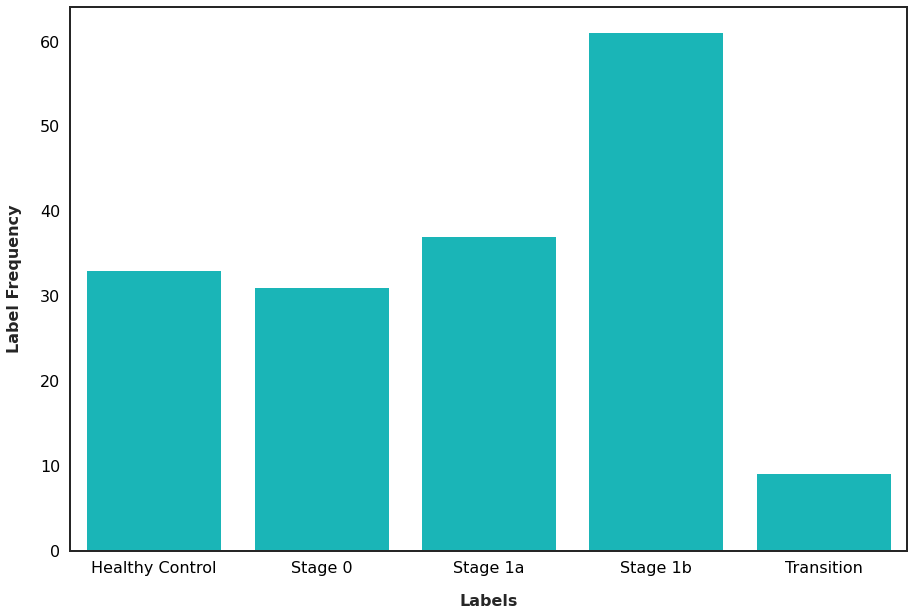

In [14]:
# Class Balance Analysis

def get_class_balance_plot(df, label_col, fig_title=None, plot_path=None): 
  label_counts = df.groupby(label_col).count().iloc[:, 0].rename("counts")
  if plot_path != None: 
    plt.style.use(os.path.join(plot_path, "plt_plot_style.mplstyle"))
  DIMS = [15,10]
  fig, ax = plt.subplots(figsize=DIMS)
  
  label_map = {
    "Stage_0": "Stage 0",
    "Stage_1b": "Stage 1b",
    "Stage_1a": "Stage 1a",
    "HC": "Healthy Control",
    "Transition": "Transition"
  }

  x = np.array([label_map[label] for label in label_counts.index])
  sns.barplot(x=x, y=label_counts.values,ax=ax, color='darkturquoise')
  if fig_title == None: 
    fig_title = 'Label Frequency vs. Labels'
  # ax.set_title(fig_title)
  ax.set_xlabel('Labels')
  ax.set_ylabel('Label Frequency')
  if plot_path != None: 
      save_fig(plot_path, fig)
  return fig
if __name__ == "__main__": 
  fig = get_class_balance_plot(df, 'label', plot_path=PLOT_PATH)

In [ ]:
def get_balanced_df(df, label_column='label', sample_size=None): 
  if sample_size == None: 
    sample_size = df.groupby(label_column).count().iloc[:,0].rename(label_column).min()
  balanced_dfs = []
  for label in df[label_column].unique():
     balanced_dfs.append(df.loc[df[label_column] == label].sample(sample_size))
  balanced_df = pd.concat(balanced_dfs)
  return balanced_df
if __name__ == "__main__": 
  balanced_df = get_balanced_df(df)

# Dimensionality Reduction with UMAP and PCA

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


Figured saved to /home/mklasby/Sandbox/Research/procan_connectome/procan_connectome/plotsUMAP projection of combined datasets - global only.png


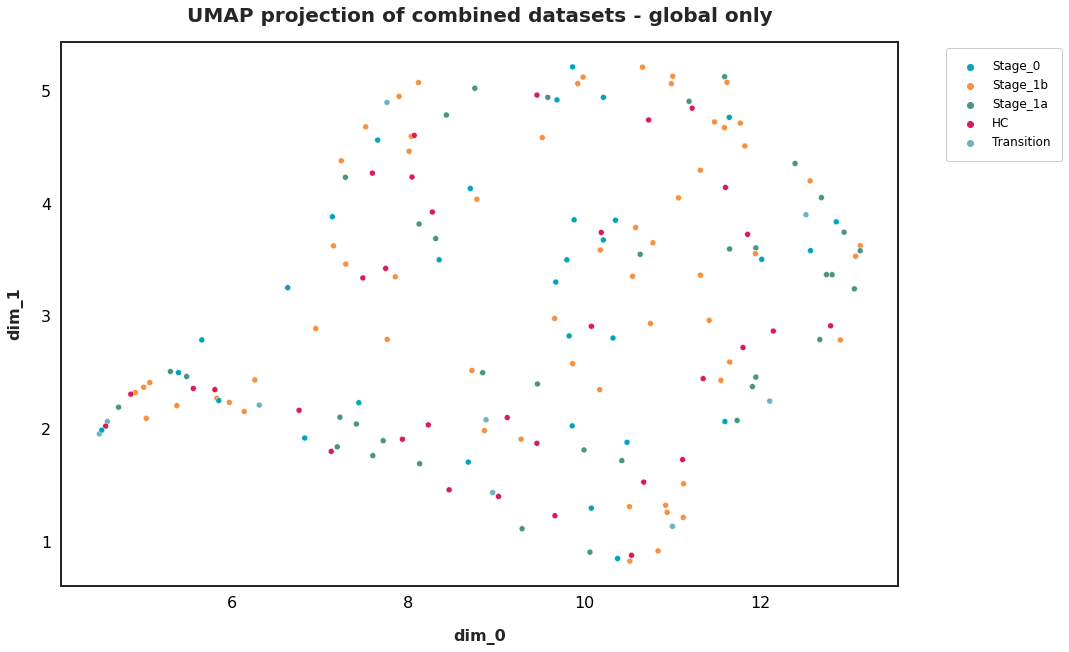

In [31]:
# UMAP Projection to 2D
if __name__ == "__main__": 
  features = df.loc[:, df.columns != "label"]
  umap_proj_arr = umap.UMAP(random_state=42).fit_transform(features)
  umap_proj_df = pd.DataFrame(umap_proj_arr, columns=["dim_0", "dim_1"])
  umap_proj_df = umap_proj_df.set_index(features.index)
  clusters_df = pd.merge(umap_proj_df, features, left_index=True, right_index=True)
  clusters_df = pd.merge(df['label'], clusters_df, left_index=True, right_index=True)
  fig = plot_clusters_2D(clusters_df, 'dim_0', 'dim_1', 'label',fig_title="UMAP projection of combined datasets - global only", plot_path=ROOT_PLOT )

Figured saved to /home/mklasby/Sandbox/Research/procan_connectome/procan_connectome/plotsPCA 2D decomposition of combined datasets - global only.png


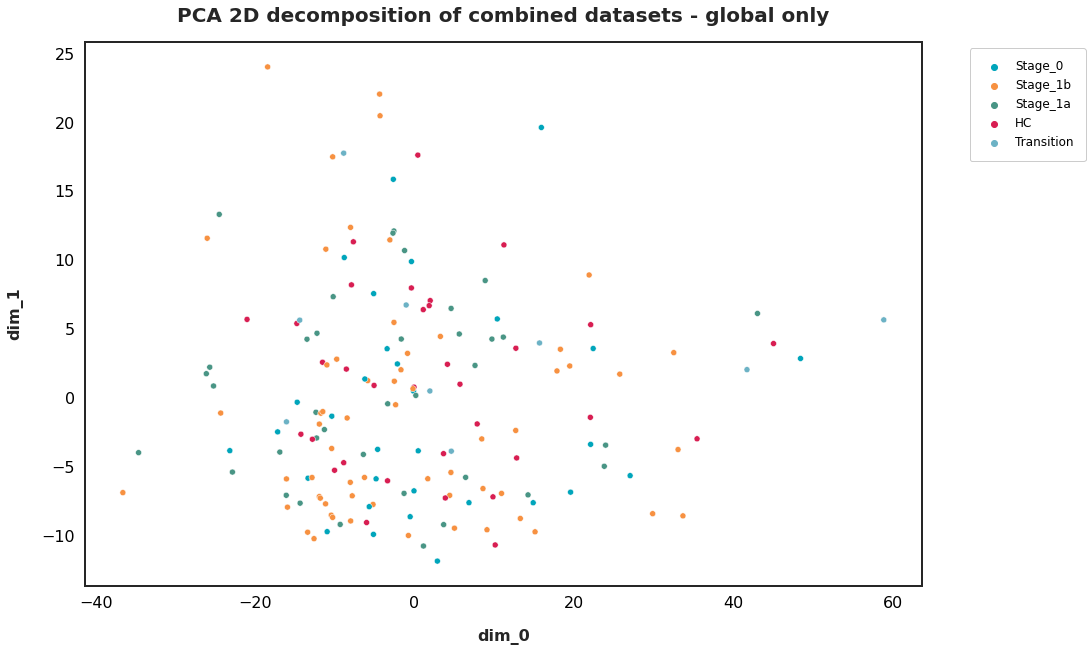

In [32]:
# PCA to 2 or 3 dimensions
from sklearn.decomposition import PCA
if __name__ == "__main__": 
  features = df.loc[:, df.columns != "label"]
  pca = PCA(n_components=2, random_state=42)
  pca_df = pd.DataFrame(pca.fit_transform(features), columns=["dim_0", "dim_1"]).set_index(features.index)
  pca_df = pd.merge(df['label'], pca_df, left_index=True, right_index=True)
  fig = plot_clusters_2D(pca_df, 'dim_0', 'dim_1', 'label',fig_title="PCA 2D decomposition of combined datasets - global only", plot_path=ROOT_PLOT )

# Feature Analysis with all features

In [ ]:
# Random Forest Wrapper for LOOCV

from sklearn.model_selection import LeaveOneOut
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, PowerTransformer

def rf_loovc(X: pd.DataFrame, y: pd.Series, standard_scale: bool=False, power_transform:bool=False): 
  loo = LeaveOneOut()
  importances = []
  y_true = []
  y_predict = []

  for train_idx, test_idx in loo.split(X):
    X_train, X_test = X.iloc[train_idx, :], X.iloc[test_idx, :]
    y_train, y_test = y[train_idx], y[test_idx]
    if standard_scale: 
      std_scaler = StandardScaler()
      X_train = std_scaler.fit_transform(X_train)
      X_test = std_scaler.transform(X_test)
    if power_transform: 
      pt = PowerTransformer()
      X_train = pt.fit_transform(X_train)
      X_test = pt.transform(X_test)
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train,y_train)
    importances.append(rf.feature_importances_)
    y_predict.append(rf.predict(X_test)[0])
    y_true.append(y_test[0])

  acc = accuracy_score(y_true, y_predict)
  print(f"Accuracy: {acc}")
  labels = X.columns
  feature_importances = np.array(importances).mean(axis=0)
  feature_importances_df = pd.DataFrame(sorted(zip(map(lambda x: round(x,6), feature_importances), labels), reverse=True), columns=["Importance", "Feature"])
  print("Features sorted by score:")
  display(feature_importances_df)
  results_df = pd.DataFrame({
      "y_true": y_true,
      'y_pred': y_predict
  }).set_index(X.index)
  return results_df, feature_importances_df
  
if __name__ == "__main__": 
  X, y = df.drop(columns="label"), df['label']
  results_df, feature_importances_df = rf_loovc(X, y, False, False)
  feature_importances_df.to_csv(f"{ROOT_RESULTS}feature_importances.csv", index=False)

Accuracy: 0.3216374269005848
Features sorted by score:


,Importance,Feature
0,0.003168,str-CustomPc_normalized-Temporal Pole Mid R
1,0.002982,str-NCp-Cuneus L
2,0.002699,fun-NCp-Hippocampus L
3,0.002363,str-NLe-Parietal Inf R
4,0.002285,fun-Bc-Postcentral R
...,...,...
1354,0.000232,fun-Dc-Rolandic Oper L
1355,0.000217,str-Dc-Occipital Mid L
1356,0.000193,str-SumEdgeNum_Within_Module04
1357,0.000185,str-SumEdgeNum_Between_Module03_04


Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/All Feature Confusion Matrix.png


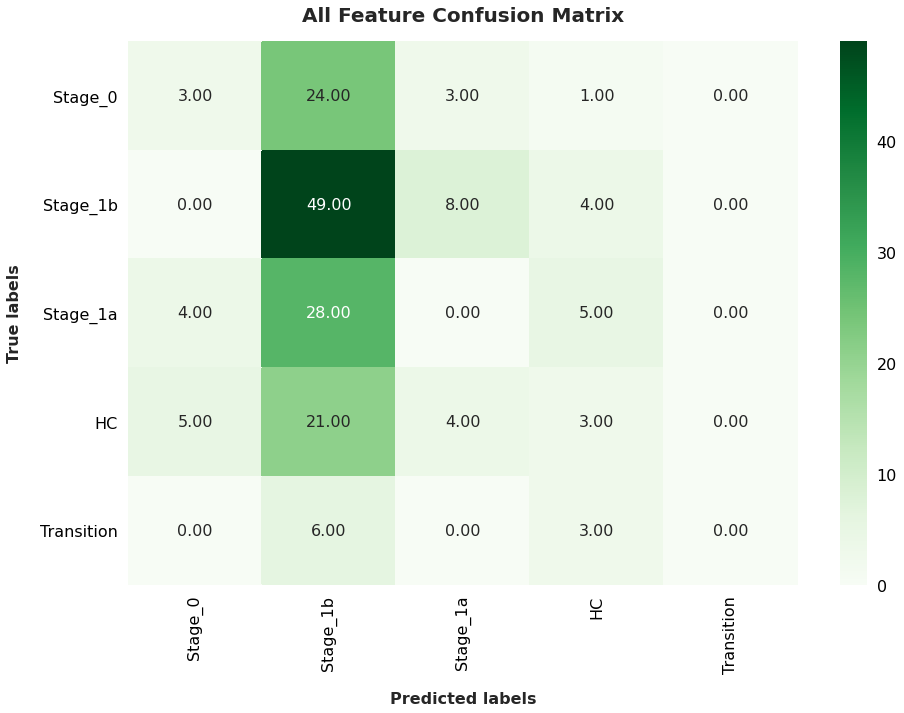

In [ ]:
# Confusion matrix 
if __name__ == "__main__": 
  labels = results_df['y_true'].unique()
  cm = confusion_matrix(results_df['y_true'], results_df['y_pred'], labels=labels)
  fig = confusion_matrix_plot(cm, labels, fig_title= "All Feature Confusion Matrix", plot_path=ROOT_PLOT)

In [ ]:
if __name__ == "__main__": 
  fig = plot_feature_importance(feature_importances_df, "Full Data Feature Importances", feature_col='Feature', importance_col='Importance', plot_path=ROOT_PLOT)

Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/TOP 10 Full Data Feature Importances.png


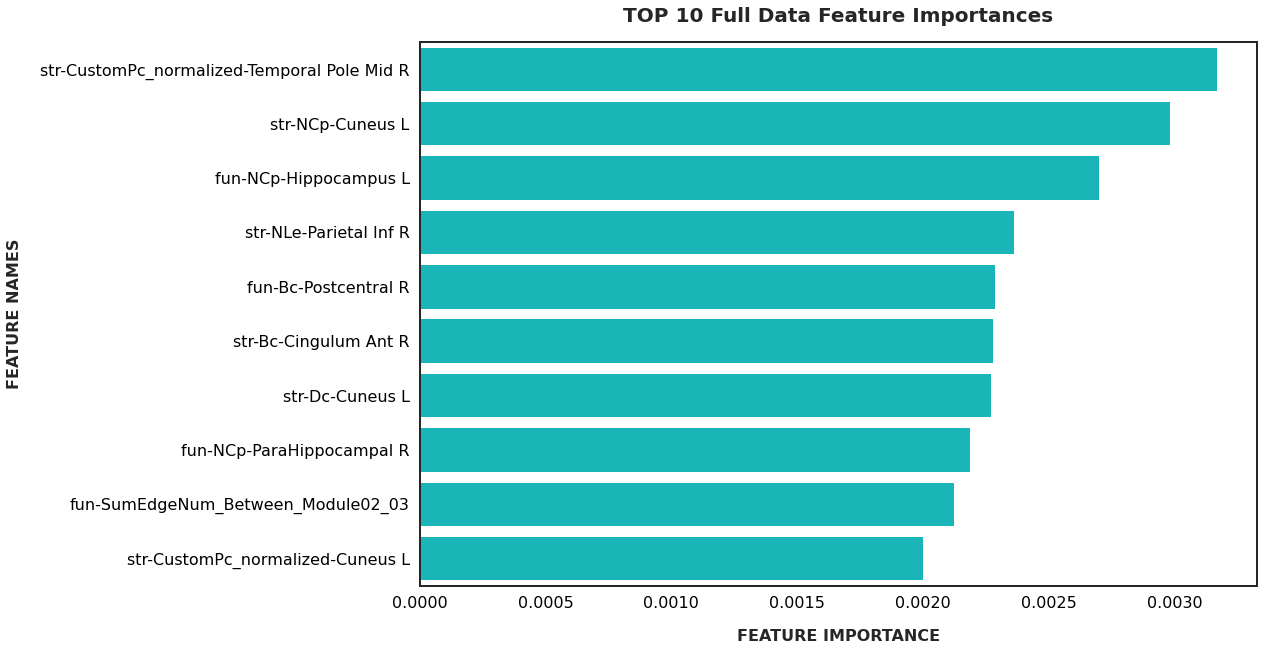

In [ ]:
if __name__ == "__main__": 
  fig = plot_feature_importance(feature_importances_df, "TOP 10 Full Data Feature Importances", feature_col='Feature', importance_col='Importance', n_features=10, plot_path=ROOT_PLOT)

Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/UMAP projection of 0.02% features.png


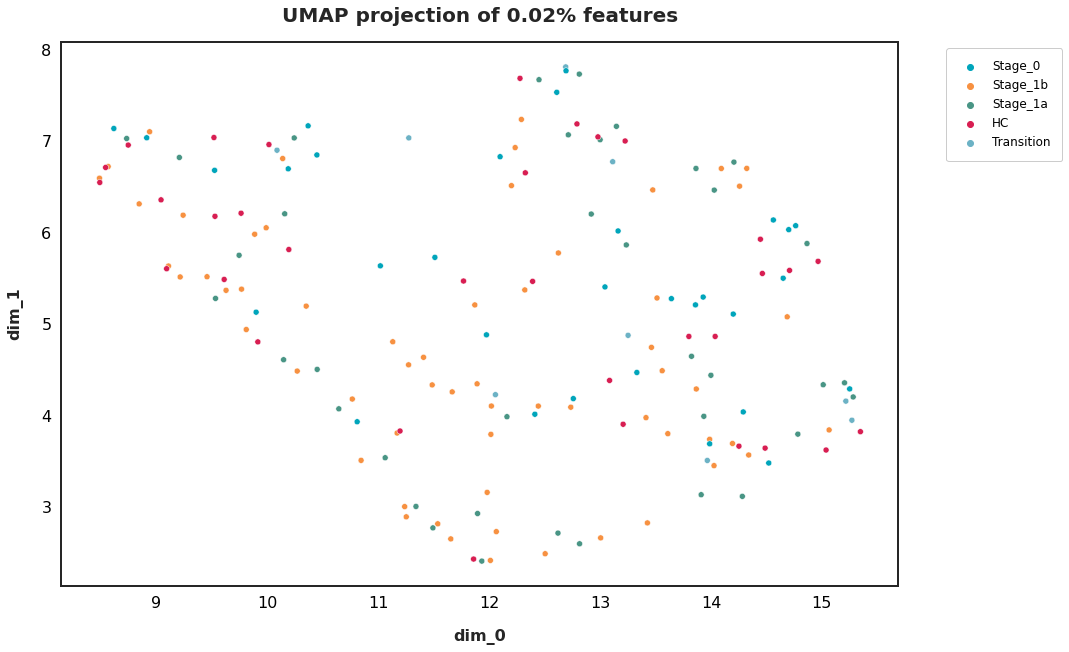

In [ ]:
# UMAP Projection to 2D
if __name__ == "__main__": 
  THRESHOLD = 0.002
  df_top_features_002 = get_important_features(df, feature_importances_df, threshold=THRESHOLD)
  features = df_top_features_002.loc[:, df_top_features_002.columns != "label"]
  umap_proj_arr = umap.UMAP(random_state=42).fit_transform(features)
  umap_proj_df = pd.DataFrame(umap_proj_arr, columns=["dim_0", "dim_1"])
  umap_proj_df = umap_proj_df.set_index(features.index)
  clusters_df = pd.merge(umap_proj_df, features, left_index=True, right_index=True)
  clusters_df = pd.merge(df['label'], clusters_df, left_index=True, right_index=True)
  fig = plot_clusters_2D(clusters_df, 'dim_0', 'dim_1', 'label',fig_title="UMAP projection of 0.02% features", plot_path=ROOT_PLOT )

Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/PCA 2D decomposition of 0.02% features.png


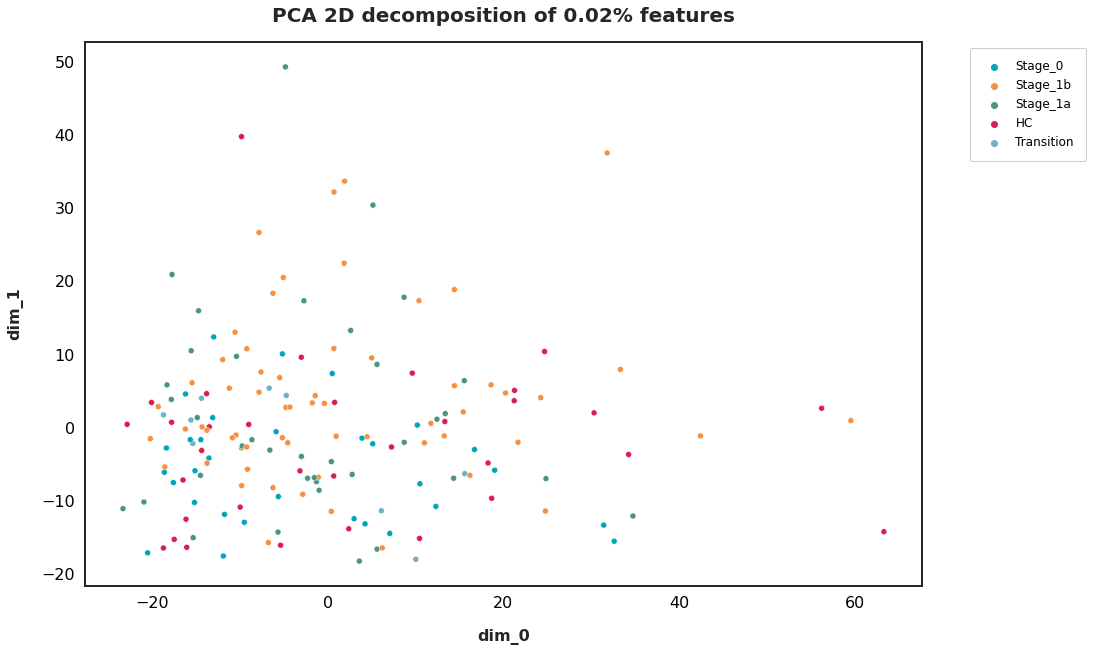

In [ ]:
# PCA to 2 or 3 dimensions
from sklearn.decomposition import PCA
if __name__ == "__main__": 
  df_top_features_002 = get_important_features(df, feature_importances_df, threshold=THRESHOLD)
  features = df_top_features_002.loc[:, df_top_features_002.columns != "label"]
  pca = PCA(n_components=2, random_state=42)
  pca_df = pd.DataFrame(pca.fit_transform(features), columns=["dim_0", "dim_1"]).set_index(features.index)
  pca_df = pd.merge(df['label'], pca_df, left_index=True, right_index=True)
  fig = plot_clusters_2D(pca_df, 'dim_0', 'dim_1', 'label',fig_title="PCA 2D decomposition of 0.02% features", plot_path=ROOT_PLOT )

Shape features (171, 106)
Shape umap_proj_arr (171, 2)
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/UMAP projection of PCA decomposition datasets.png


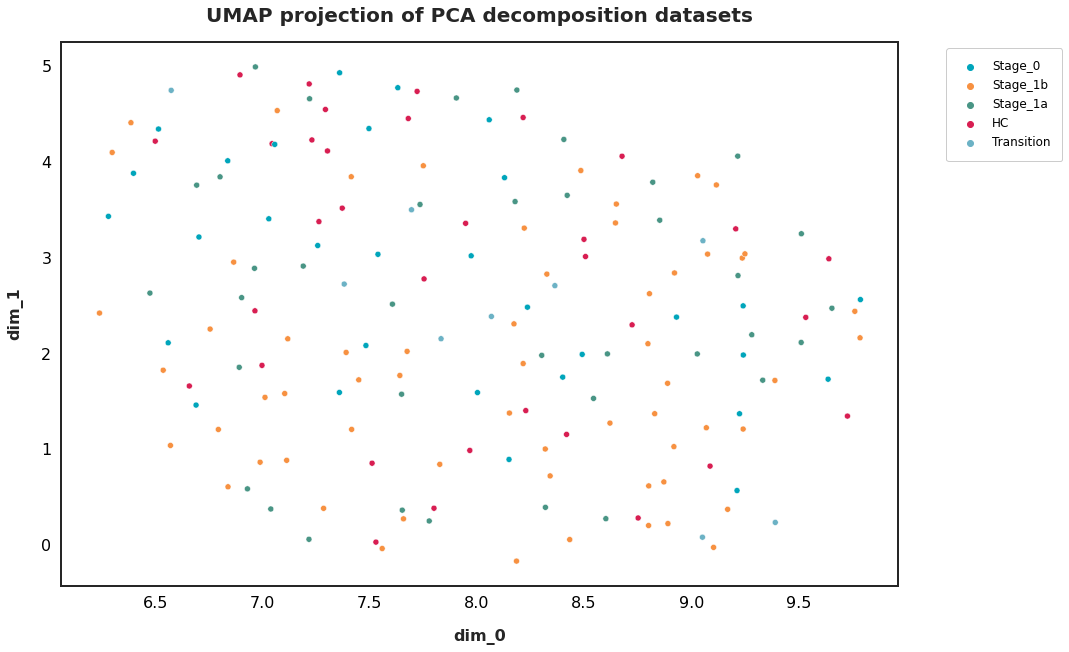

In [ ]:
# PCA to 95% and then UMAP to 2D
from sklearn.decomposition import PCA
if __name__ == "__main__": 
  # df_top_features_002 = get_important_features(df, feature_importances_df, threshold=THRESHOLD)
  features = df.loc[:, df.columns != "label"]
  pca = PCA(n_components=0.95,svd_solver='full', random_state=42)
  features = pca.fit_transform(features)
  print(f"Shape features {features.shape}")
  umap_proj_arr = umap.UMAP(random_state=42).fit_transform(features)
  print(f"Shape umap_proj_arr {umap_proj_arr.shape}")
  umap_proj_df = pd.DataFrame(umap_proj_arr, columns=["dim_0", "dim_1"])
  umap_proj_df = umap_proj_df.set_index(df.index)
  # clusters_df = pd.merge(umap_proj_df, features, left_index=True, right_index=True)
  clusters_df = pd.merge(df['label'], umap_proj_df, left_index=True, right_index=True)
  fig = plot_clusters_2D(clusters_df, 'dim_0', 'dim_1', 'label',fig_title="UMAP projection of PCA decomposition datasets", plot_path=ROOT_PLOT )

Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-CustomPc_normalized-Temporal Pole Mid R_Histogram-of-Stage_0-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-NCp-Cuneus L_Histogram-of-Stage_0-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/fun-NCp-Hippocampus L_Histogram-of-Stage_0-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-CustomPc_normalized-Temporal Pole Mid R_Histogram-of-Stage_1b-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-NCp-Cuneus L_Histogram-of-Stage_1b-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/fun-NCp-Hippocampus L_Histogram-of-Stage_1b-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-CustomPc_normalized-Tem

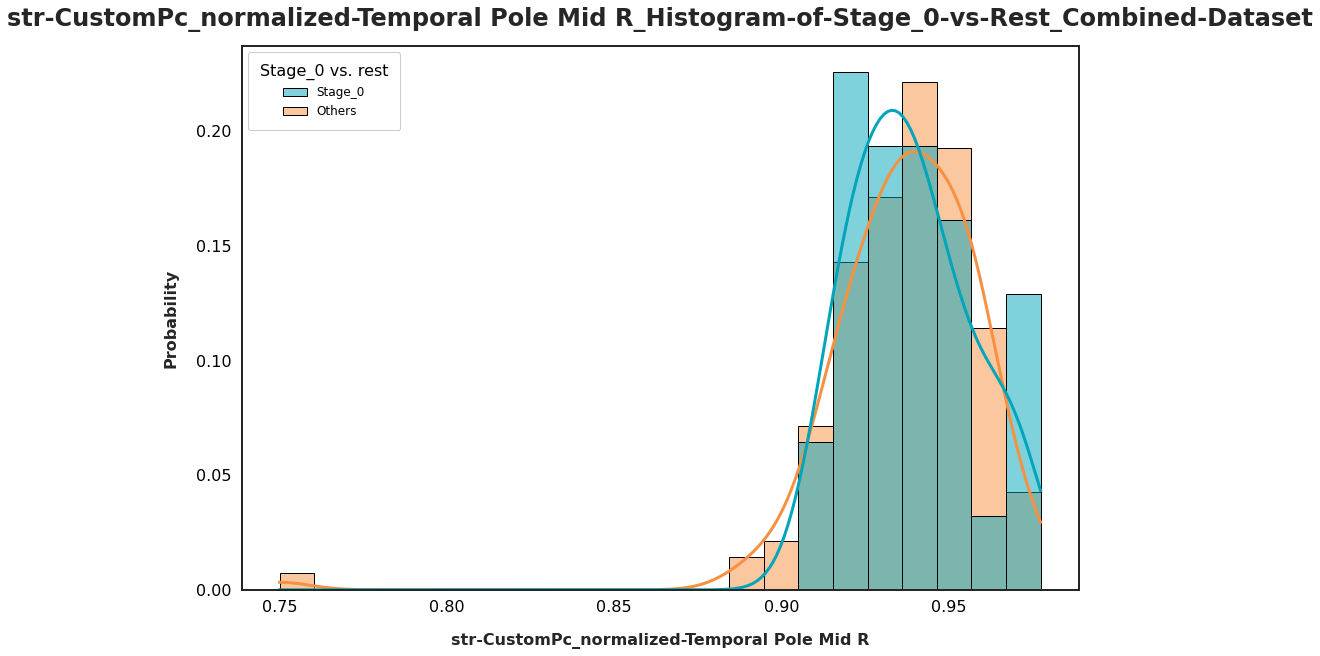

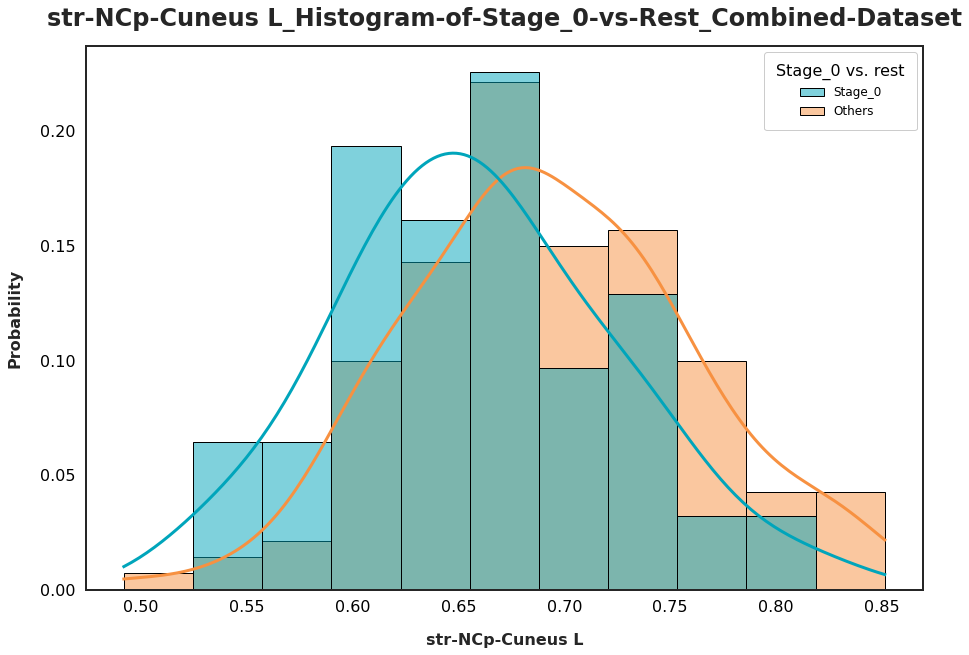

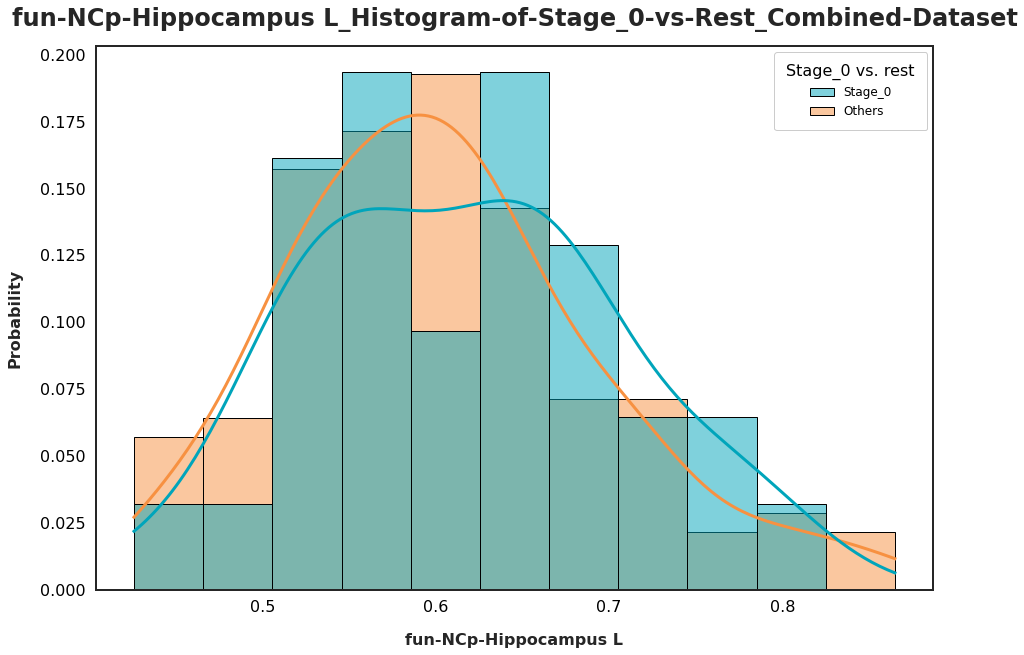

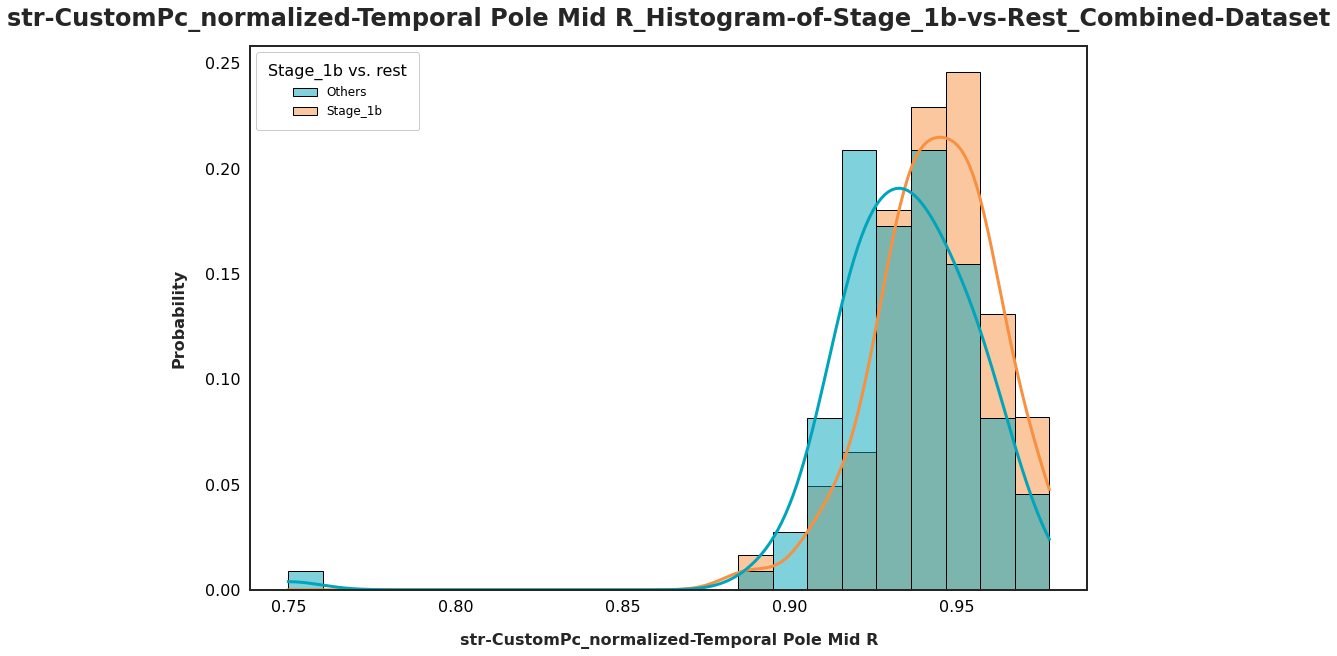

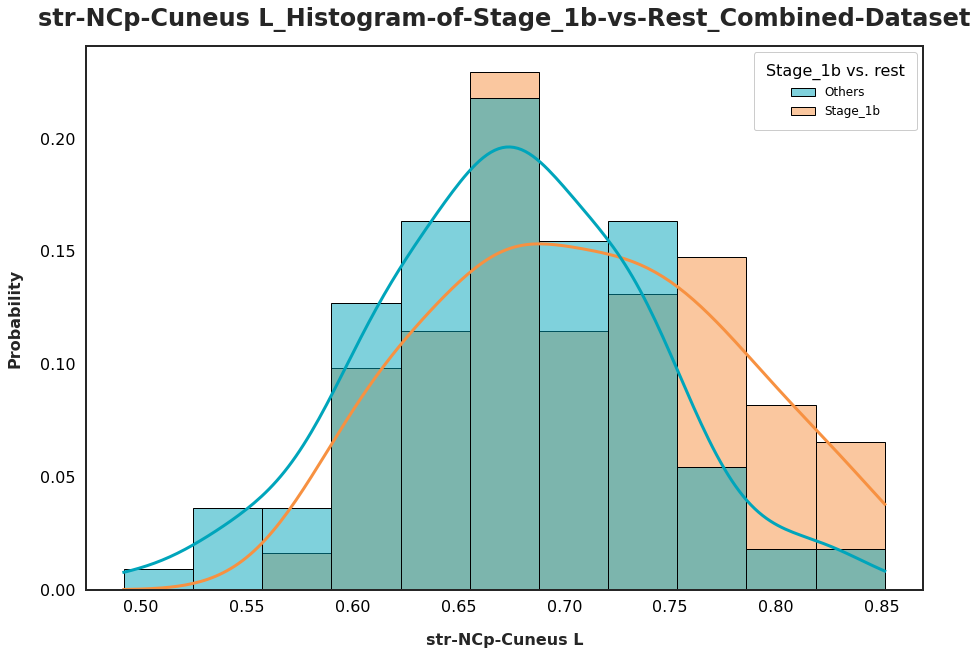

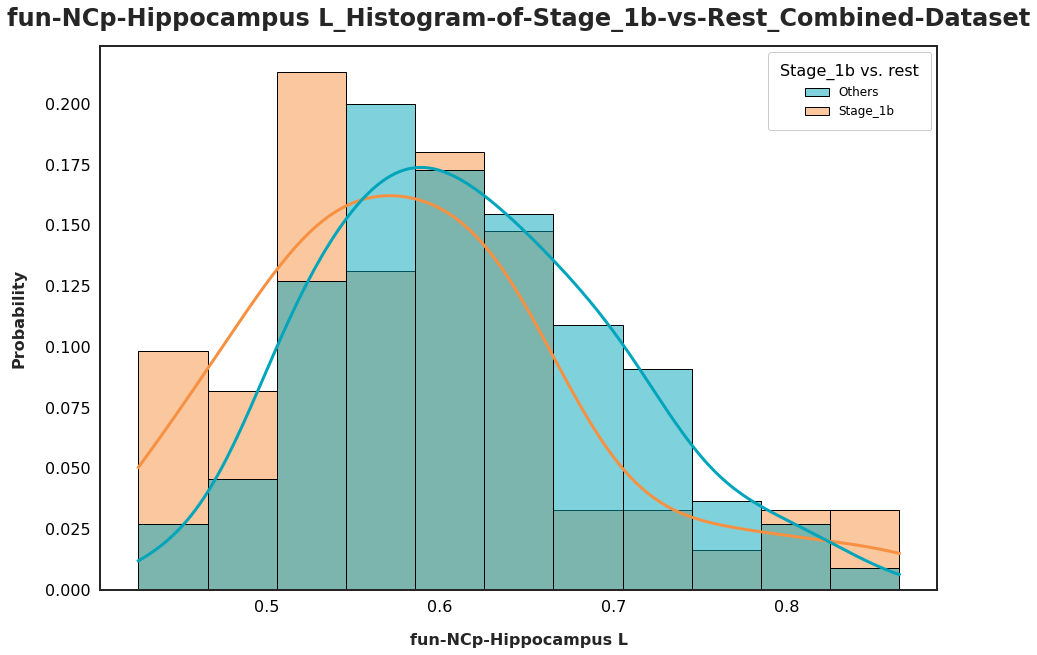

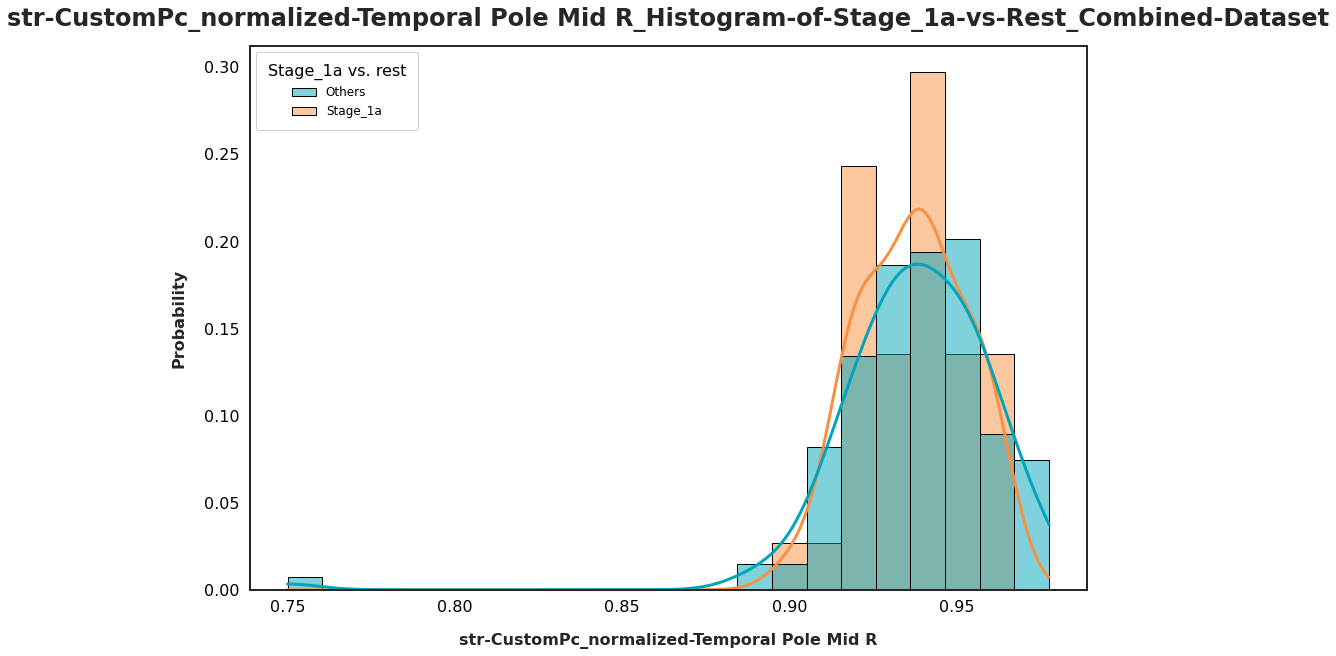

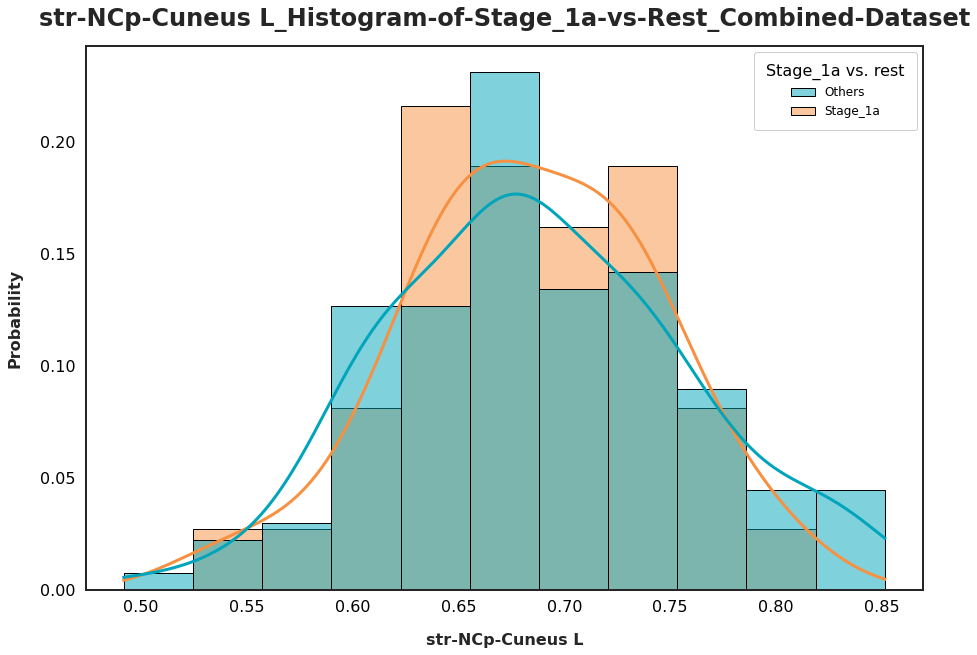

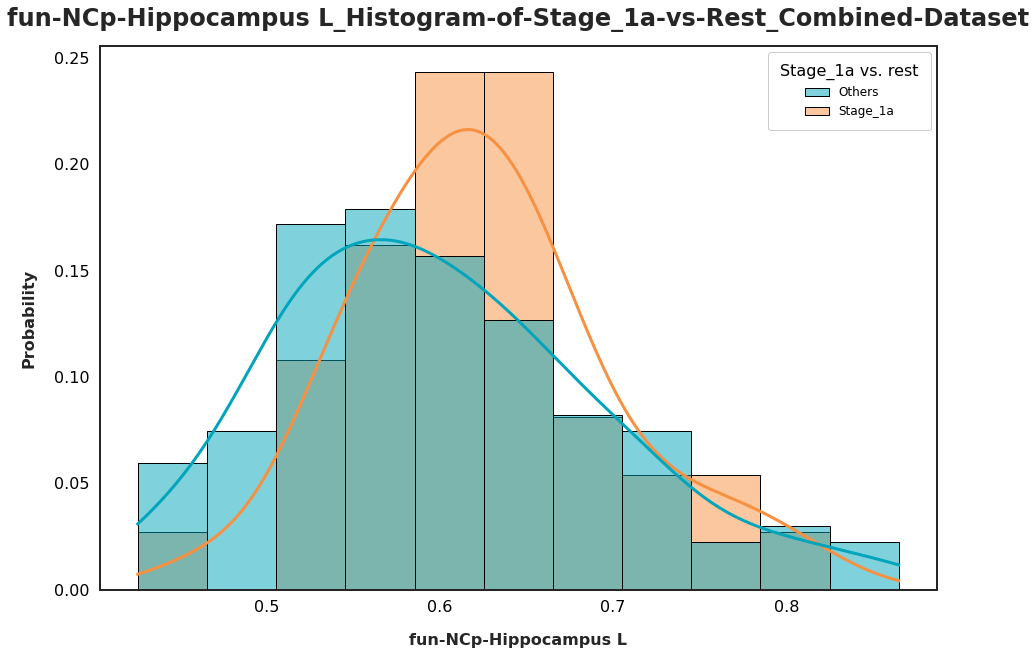

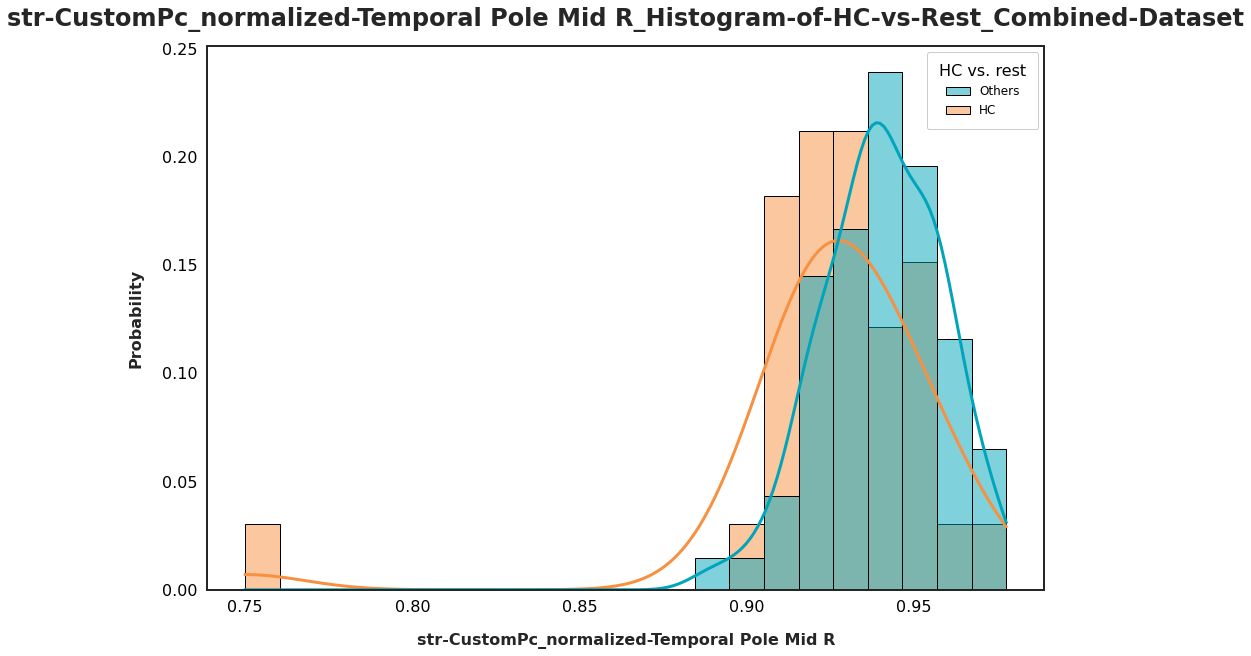

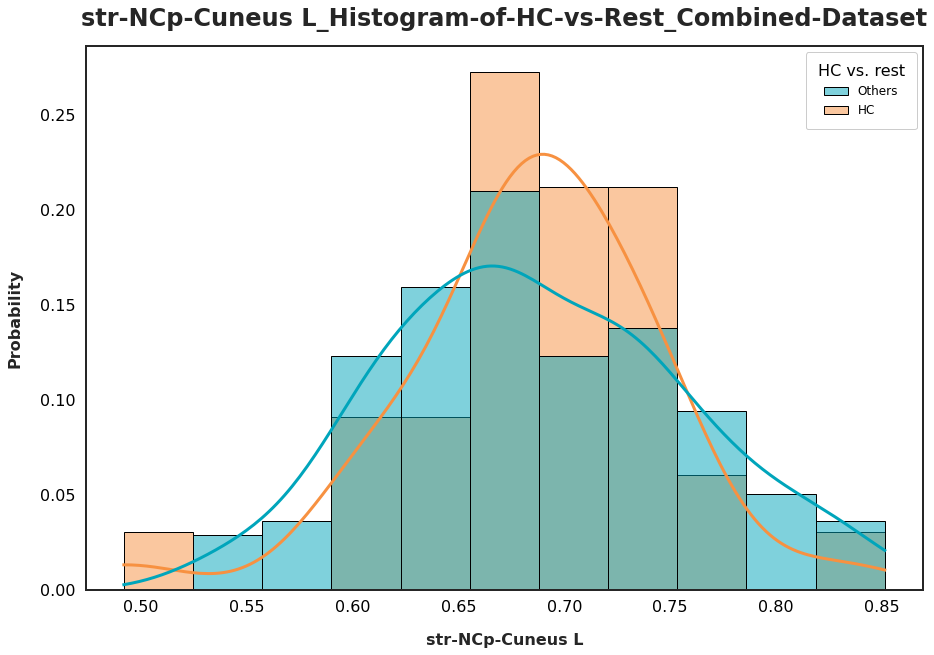

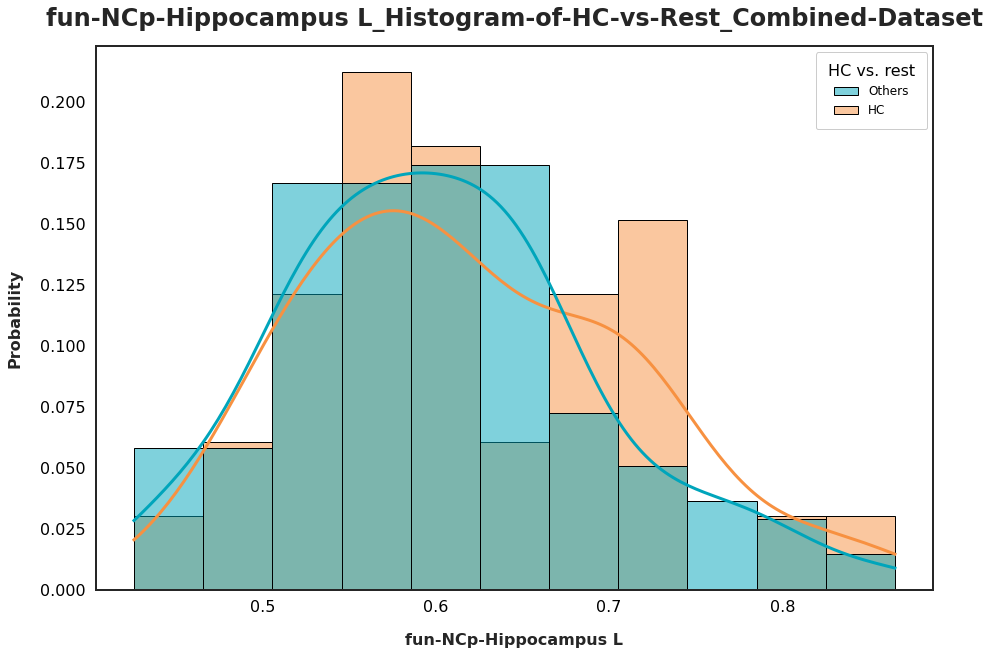

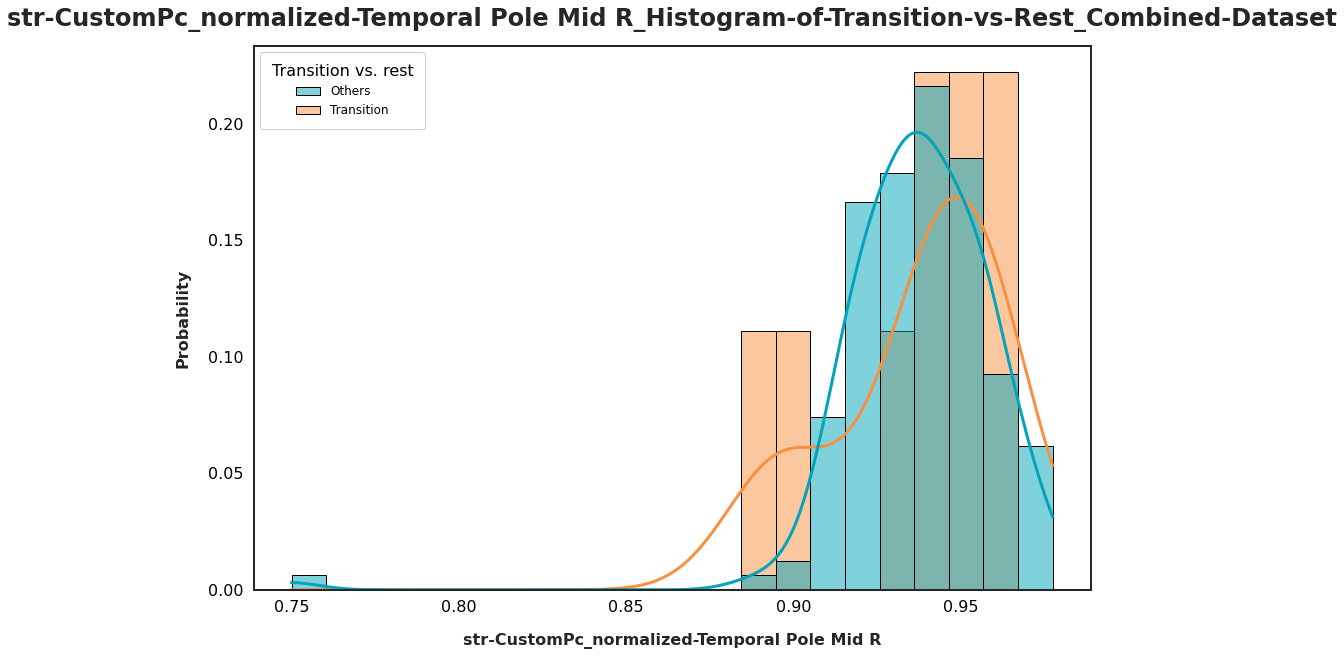

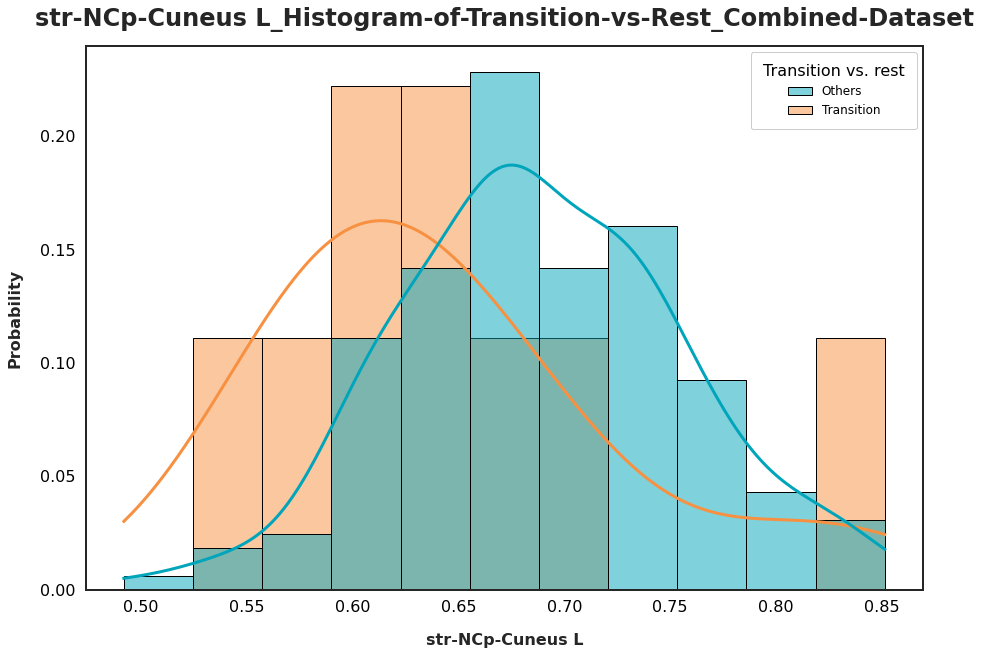

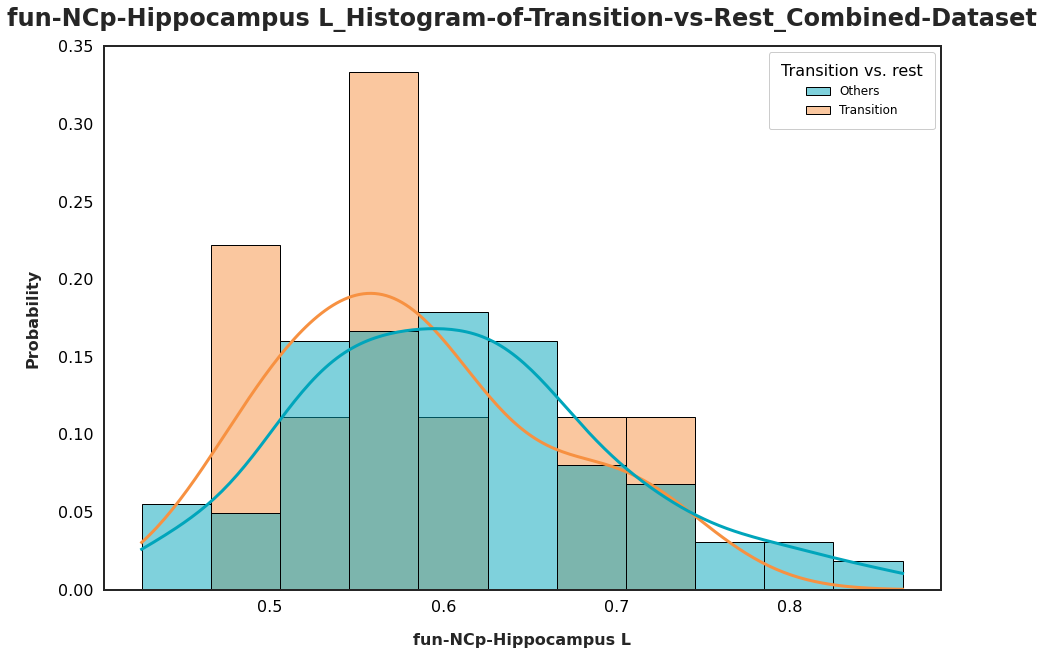

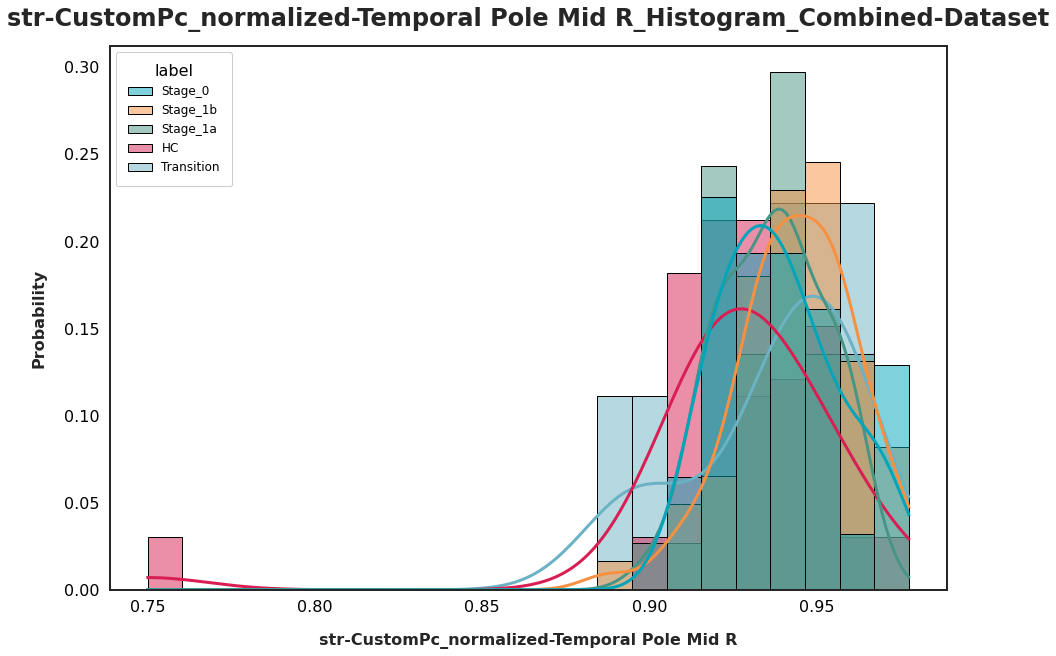

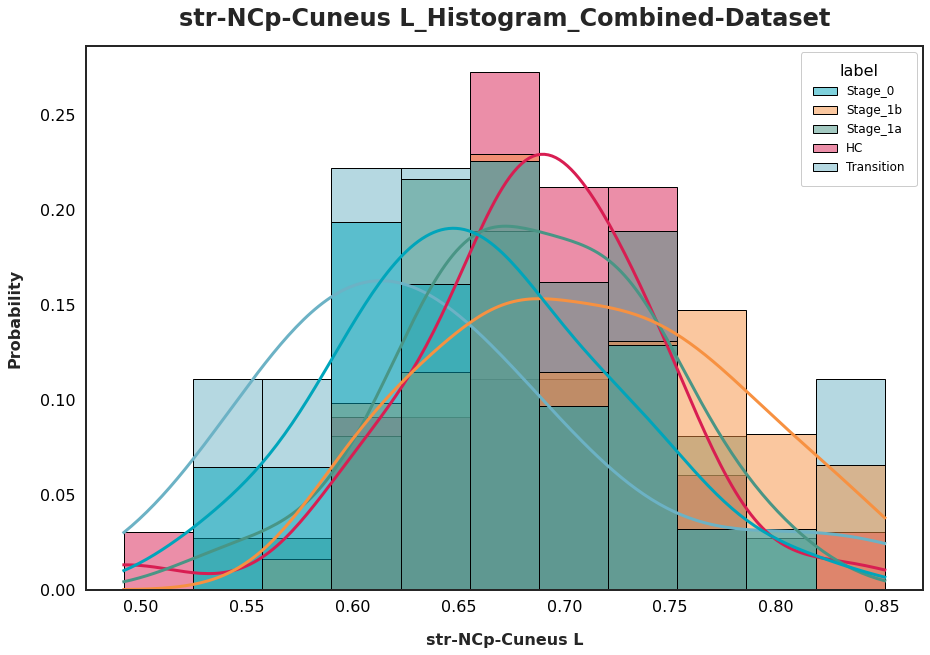

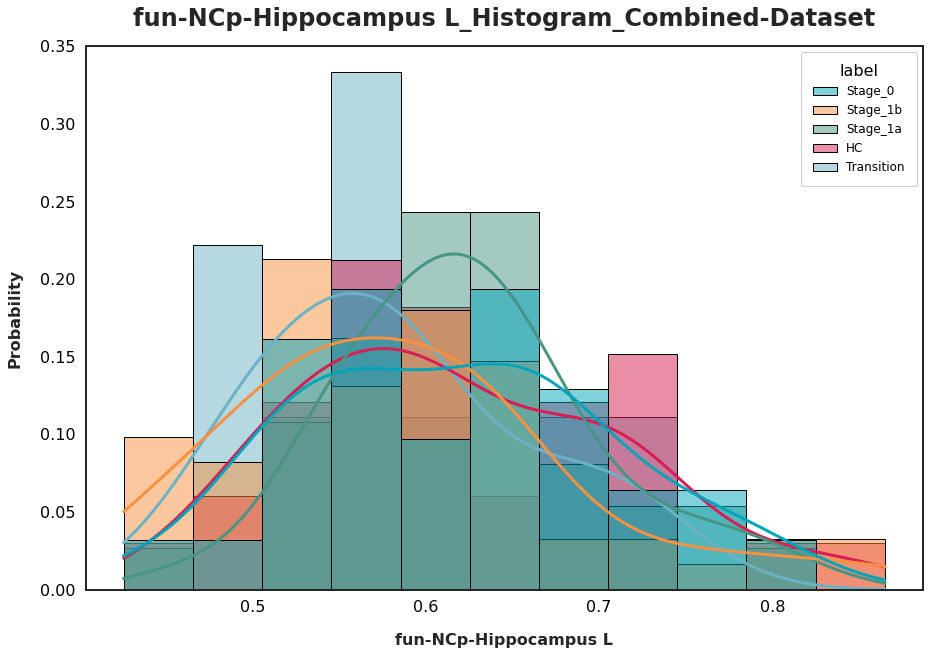

In [ ]:
if __name__ == "__main__": 
  top_features = feature_importances_df[:3]['Feature'].values.tolist()
  dist_plot_df = df.copy(deep=True)

  label_dict = {}
  for label in dist_plot_df.label.unique(): 
        label_dict[label] = get_label_ids(df, label)

  for label in label_dict:
      for feature in top_features:
          sample_name = f"{label}"
          fig_title = f"{feature}_Histogram-of-{label}-vs-Rest_Combined-Dataset"
          fig = generate_feature_dist_plot(dist_plot_df, label_dict[label], feature, sample_name, hue_col=f"{label} vs. rest", title_string=fig_title, plot_path=ROOT_PLOT)

  for feature in top_features:
    fig_title = f"{feature}_Histogram_Combined-Dataset"
    fig = generate_feature_dist_plot(dist_plot_df, [], feature, "", hue_col="label", title_string=fig_title, plot_path=ROOT_PLOT, one_vs_rest=False)

Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/Age_Histogram_Combined-Dataset_stack.png


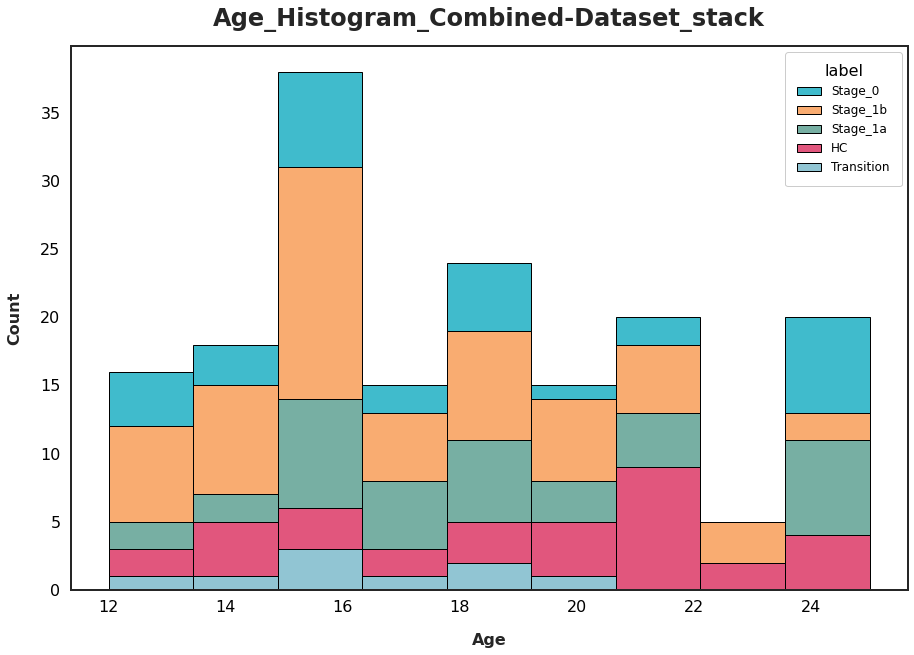

In [ ]:
if __name__ == "__main__": 
  feature = 'Age'
  fig_title = f"{feature}_Histogram_Combined-Dataset_stack"
  fig = generate_feature_dist_plot(dist_plot_df, [], feature, "", hue_col="label",
                                  title_string=fig_title, plot_path=ROOT_PLOT,
                                  one_vs_rest=False, kde=False, multiple="stack",
                                  stat='count')

Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/Age Histogram.png


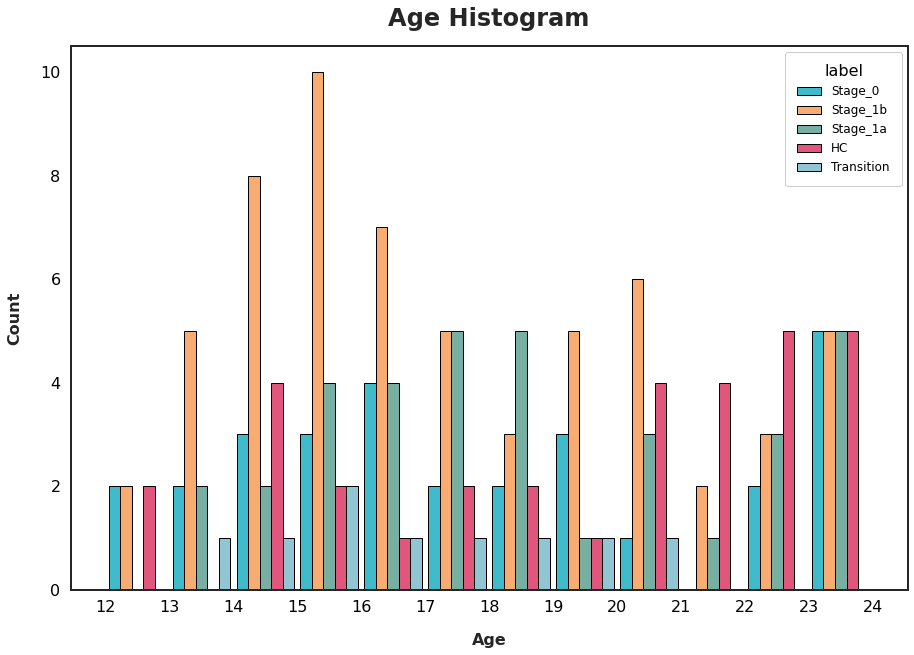

In [ ]:
if __name__ == "__main__": 
  # ages = [age for age in range(df['Age'].unique().min(), df['Age'].unique().max())]
  ages = np.arange(df['Age'].min(), df['Age'].max(), 1)
  feature = 'Age'
  fig_title = f"{feature} Histogram"
  dist_plot_df = df.copy(deep=True)
  # plt.xticks(np.arange(df['Age'].min(), df['Age'].max(), 1))
  fig = generate_feature_dist_plot(dist_plot_df, [], feature, "Age", hue="label",
                                  title_string=fig_title, plot_path=ROOT_PLOT,
                                  one_vs_rest=False, kde=False, multiple="dodge",
                                  stat='count', shrink=0.9, bins=ages, common_norm=False)

,str-CustomPc_normalized-Temporal Pole Mid R,str-NCp-Cuneus L,fun-NCp-Hippocampus L
0,0.940476,0.749249,0.694872
1,0.941429,0.628964,0.540000
2,0.943672,0.616327,0.616667
3,0.959067,0.734454,0.632411
4,0.921749,0.644820,0.786629
...,...,...,...
166,0.940408,0.640784,0.655914
167,0.931649,0.676829,0.602941
168,0.946609,0.636469,0.608696
169,0.927210,0.622642,0.557895


,str-CustomPc_normalized-Temporal Pole Mid R,str-NCp-Cuneus L,fun-NCp-Hippocampus L
0,-0.019236,0.938047,1.008289
1,0.031948,-0.834393,-0.713195
2,0.156427,-1.028134,0.222053
3,1.146203,0.727080,0.391369
4,-0.846470,-0.592917,1.812331
...,...,...,...
166,-0.022854,-0.654200,0.632494
167,-0.445962,-0.111958,0.068194
168,0.327421,-0.719861,0.133483
169,-0.633599,-0.931187,-0.479751


Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-CustomPc_normalized-Temporal Pole Mid R-Transformed_Histogram-of-Stage_0-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-NCp-Cuneus L-Transformed_Histogram-of-Stage_0-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/fun-NCp-Hippocampus L-Transformed_Histogram-of-Stage_0-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-CustomPc_normalized-Temporal Pole Mid R-Transformed_Histogram-of-Stage_1b-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/str-NCp-Cuneus L-Transformed_Histogram-of-Stage_1b-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/MyDrive/research/structural-connectivity/plots/fun-NCp-Hippocampus L-Transformed_Histogram-of-Stage_1b-vs-Rest_Combined-Dataset.png
Figured saved to ./drive/My

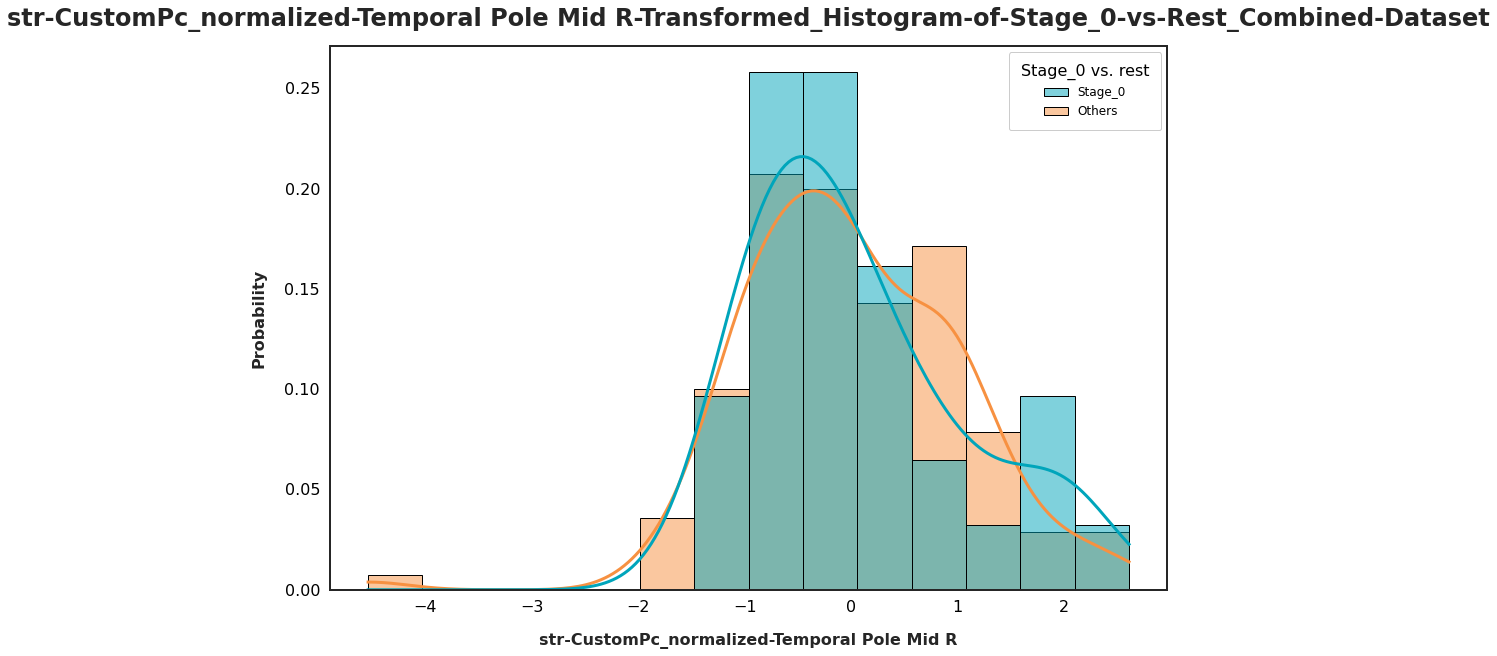

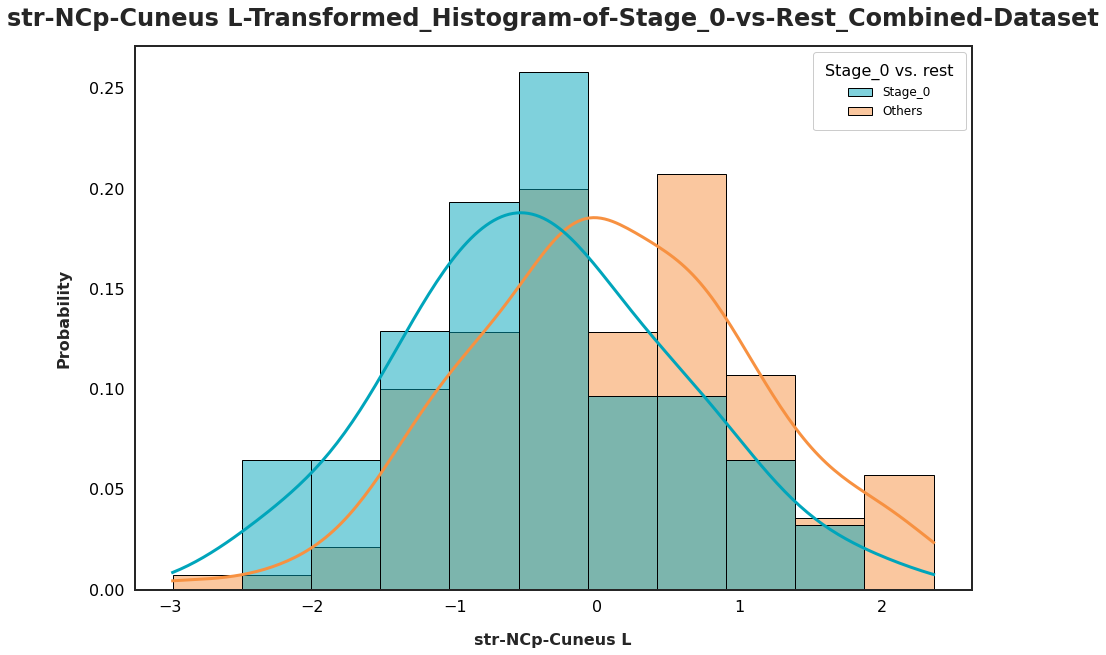

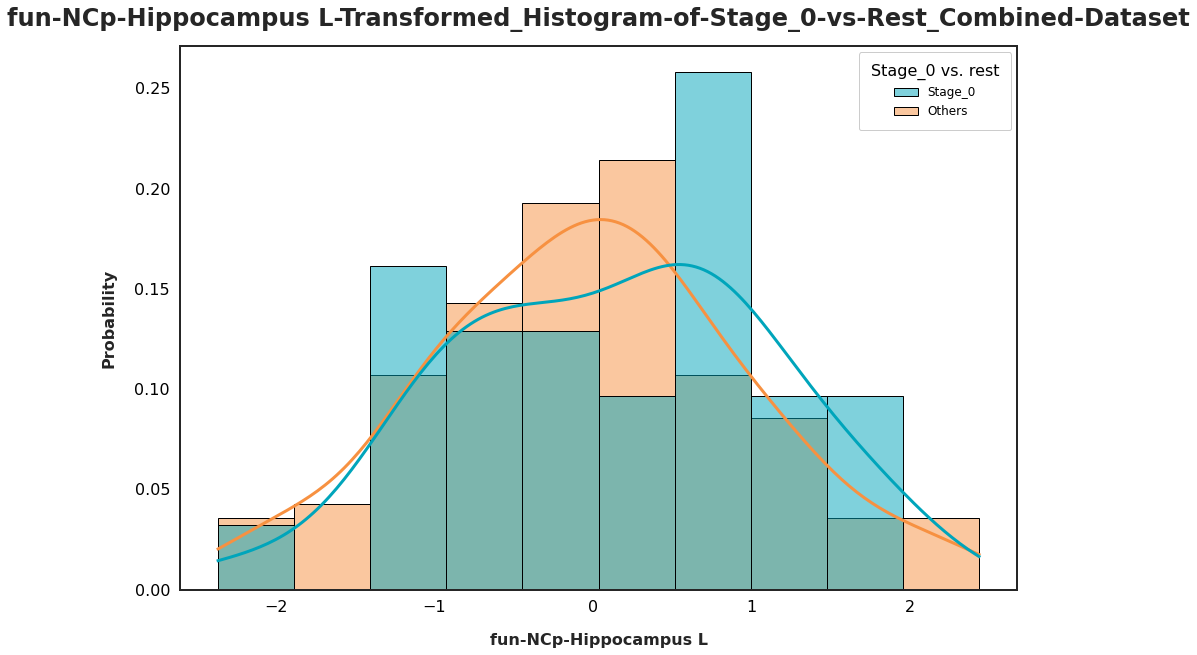

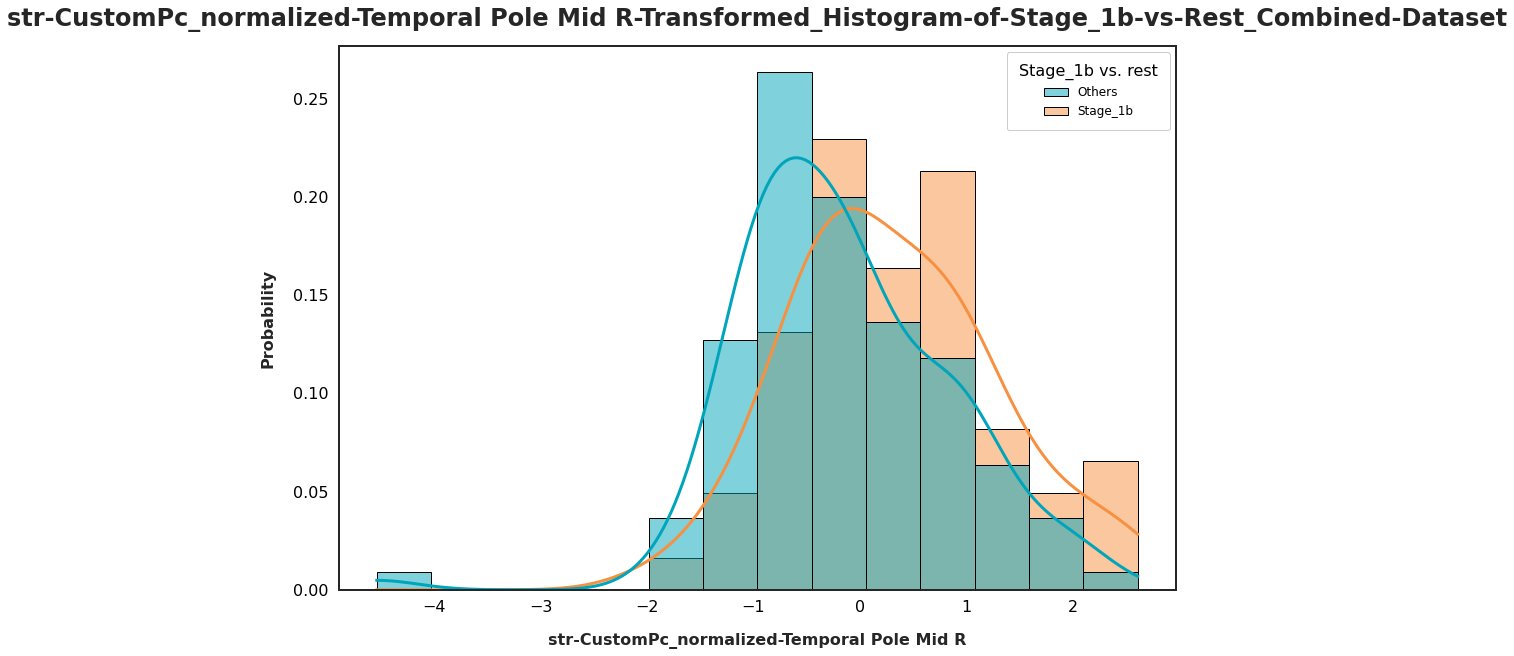

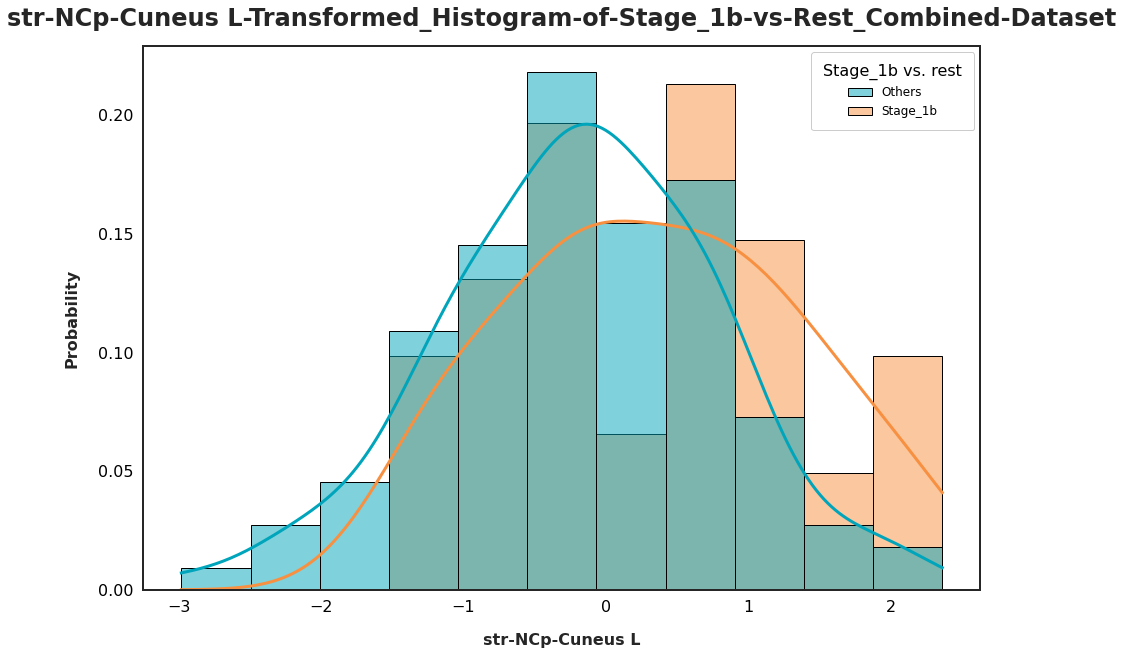

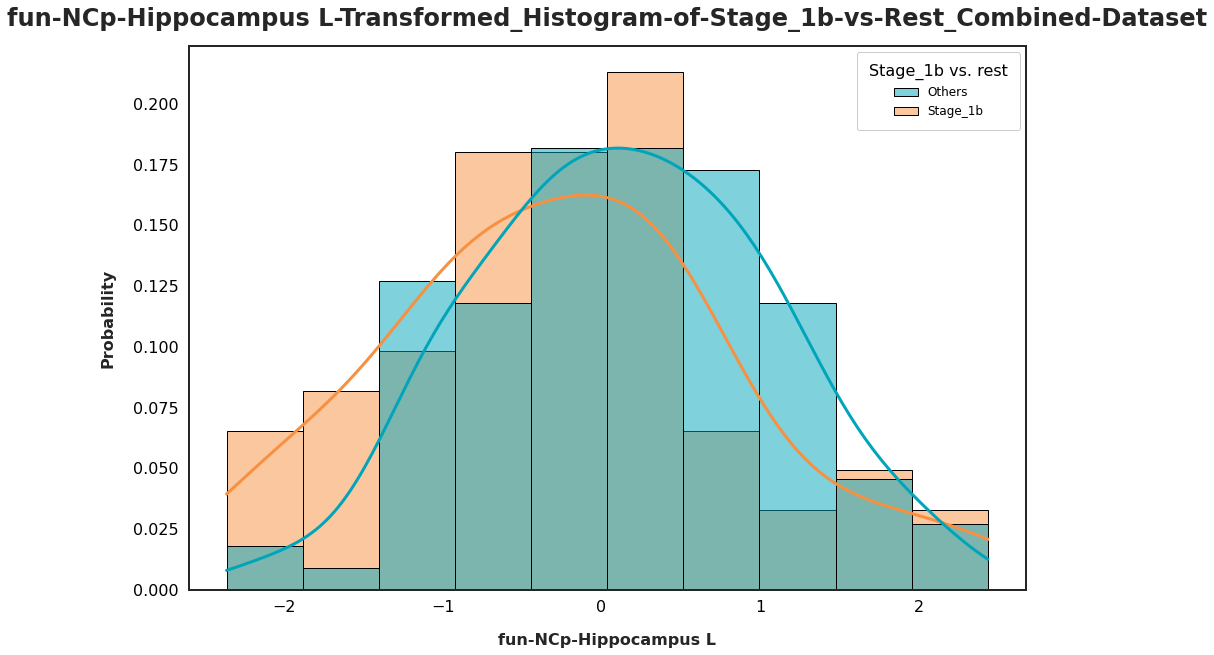

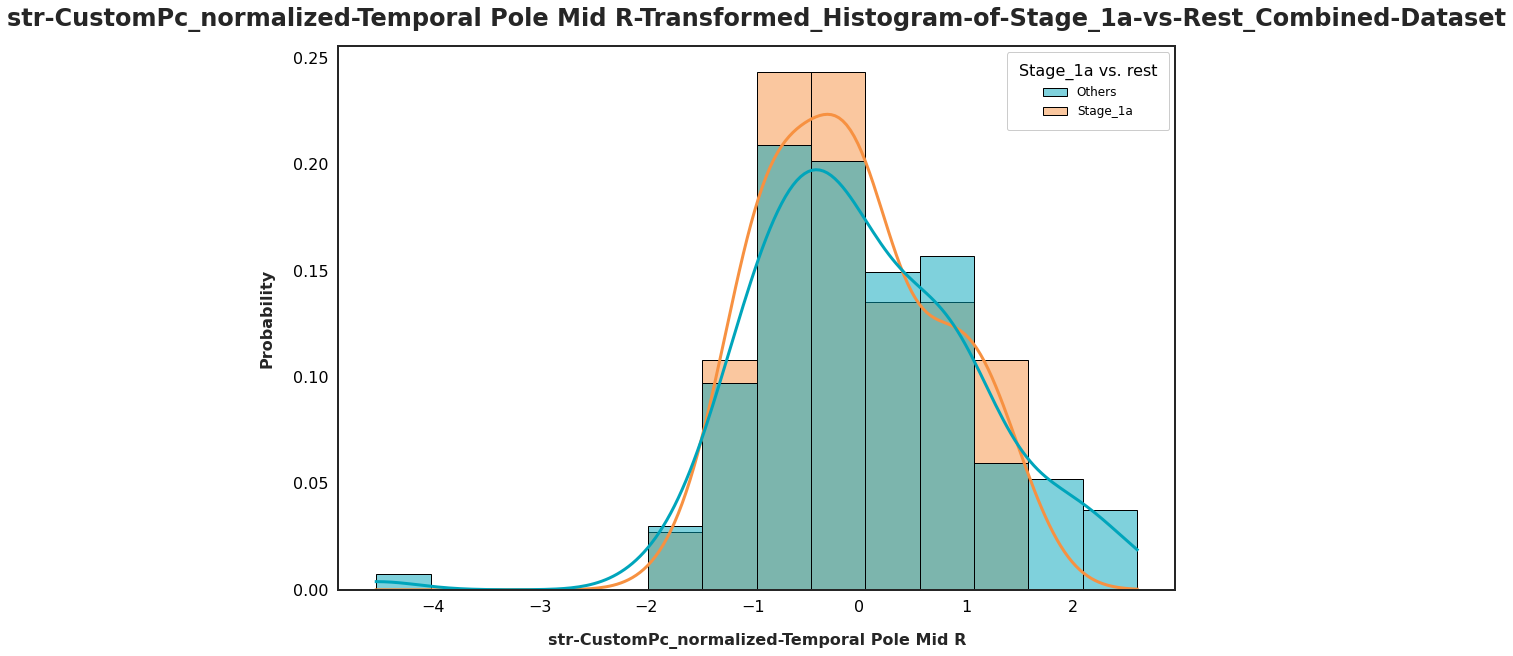

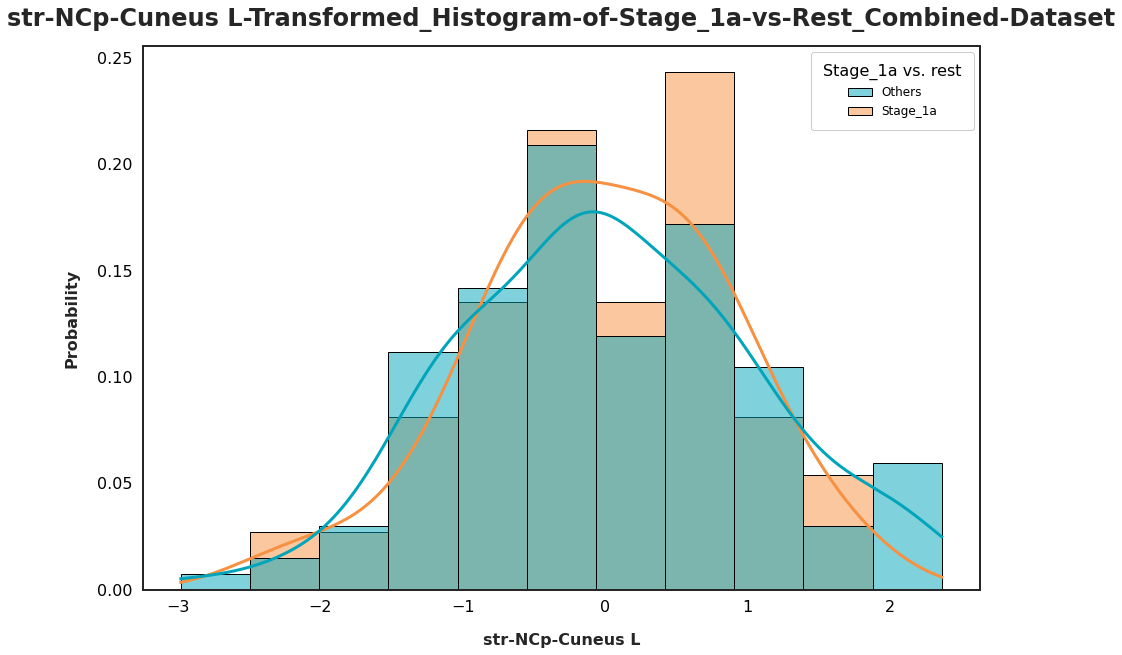

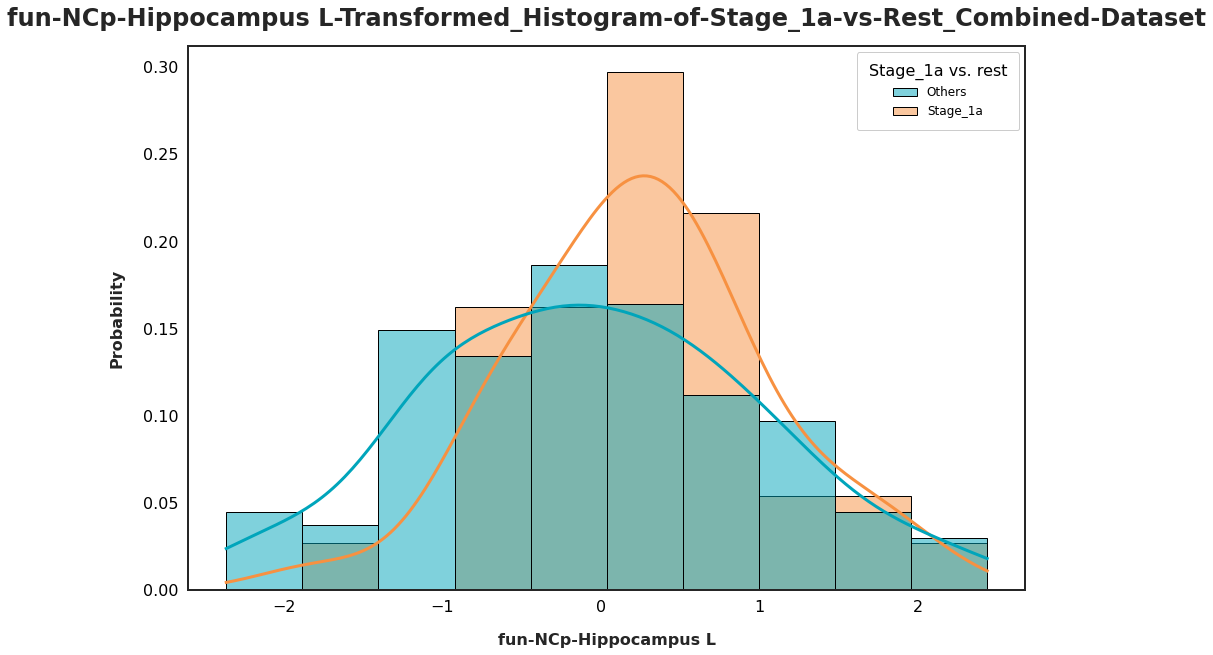

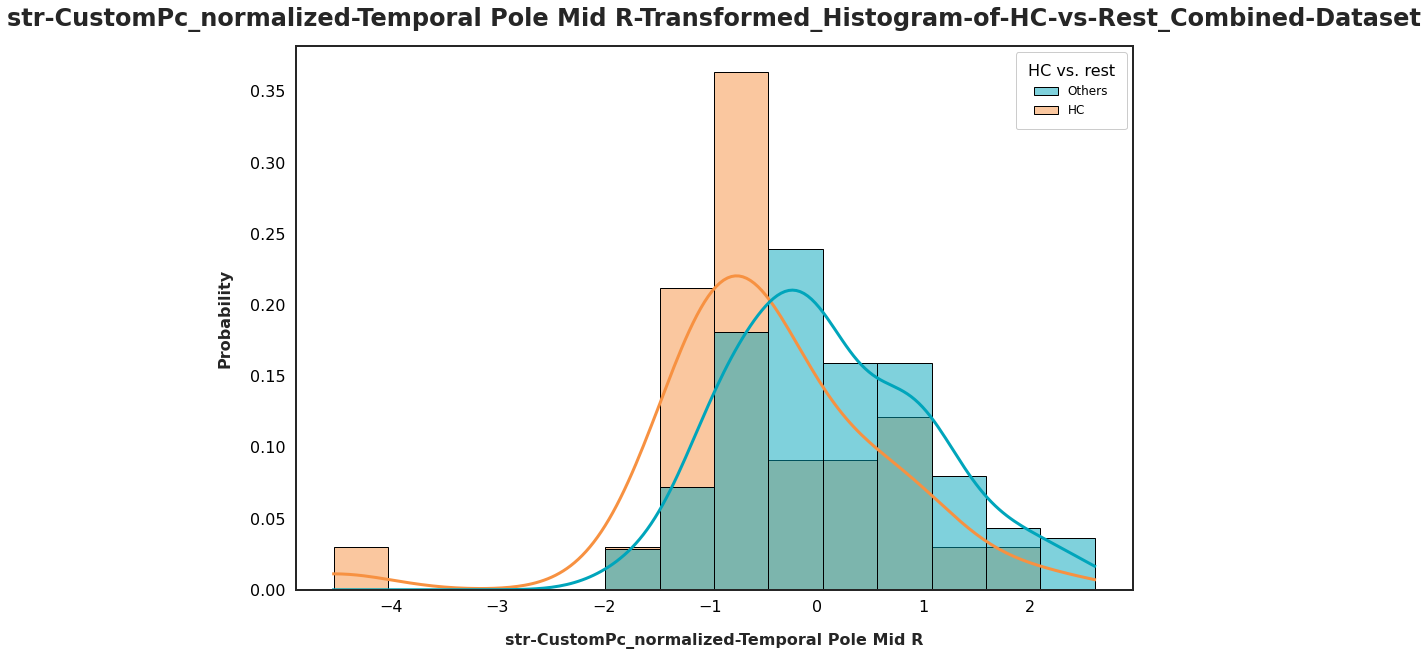

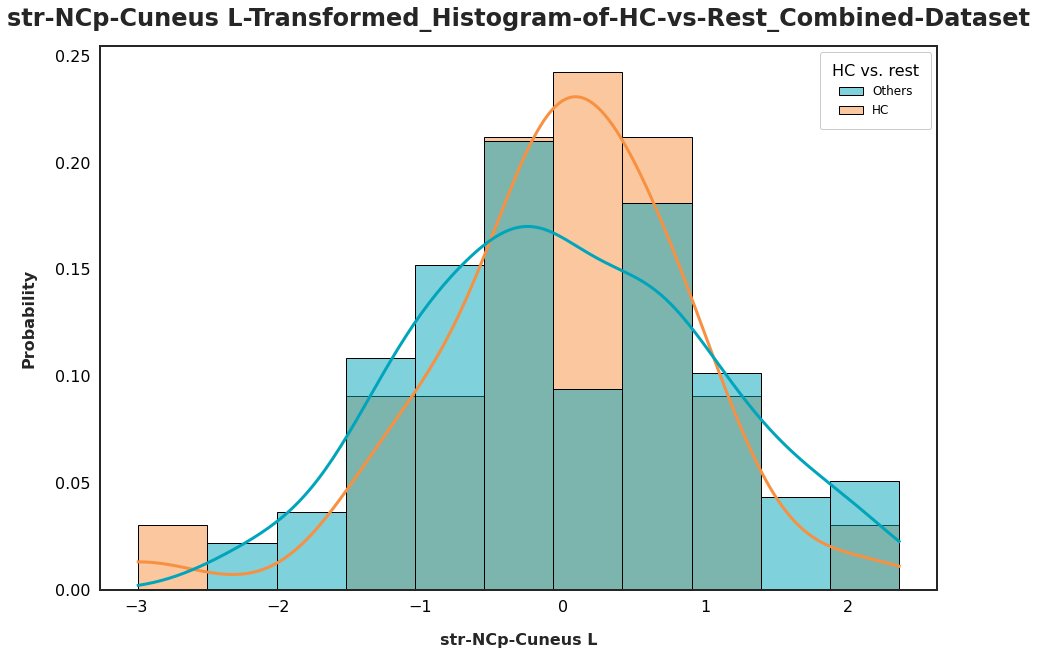

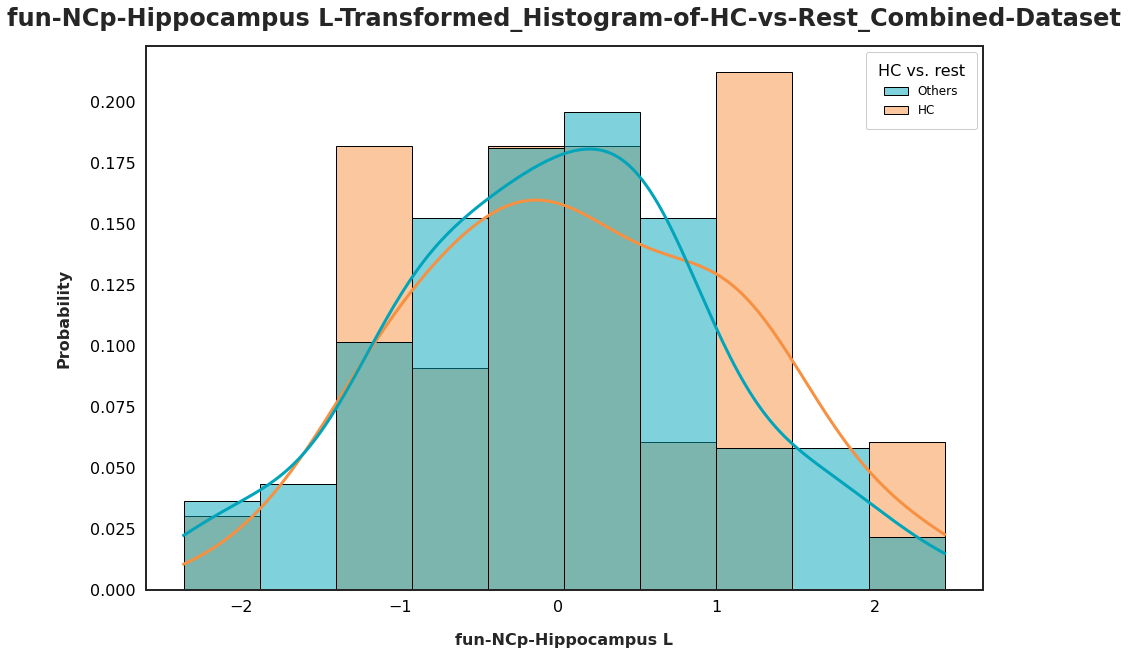

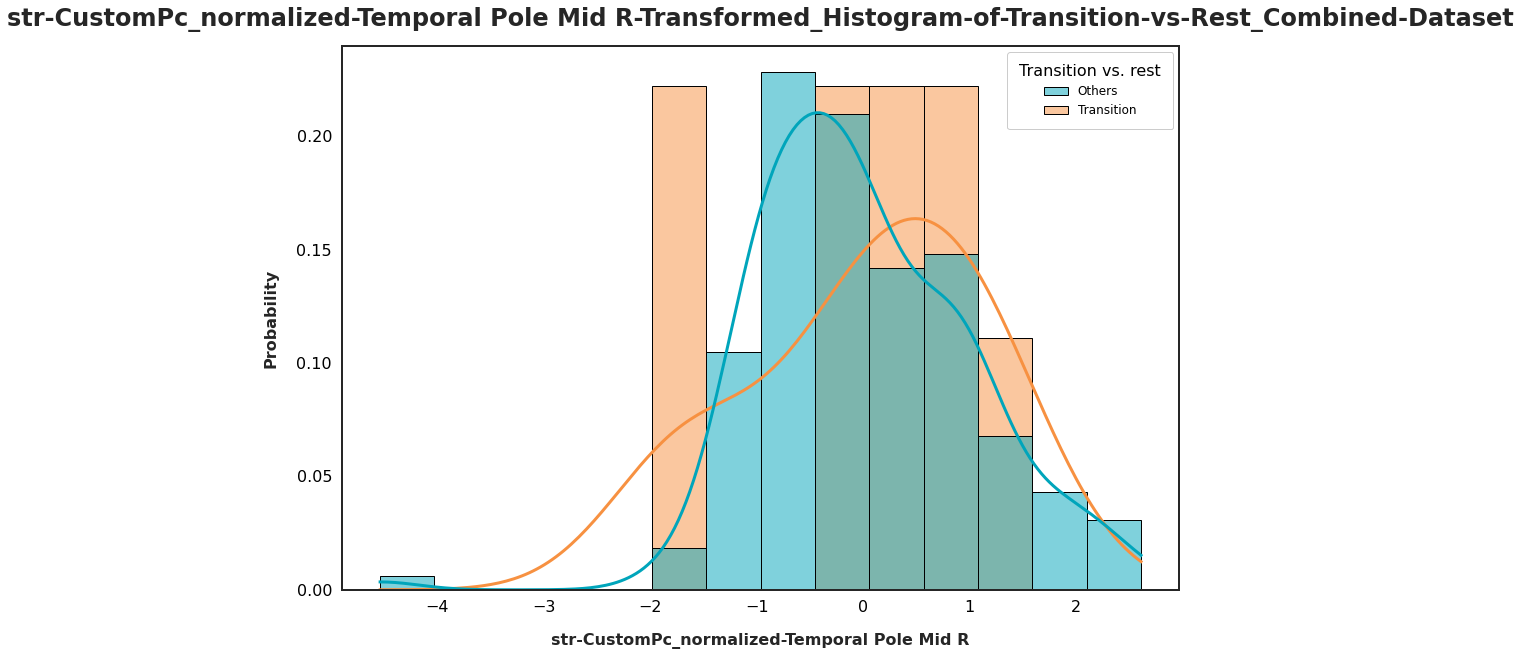

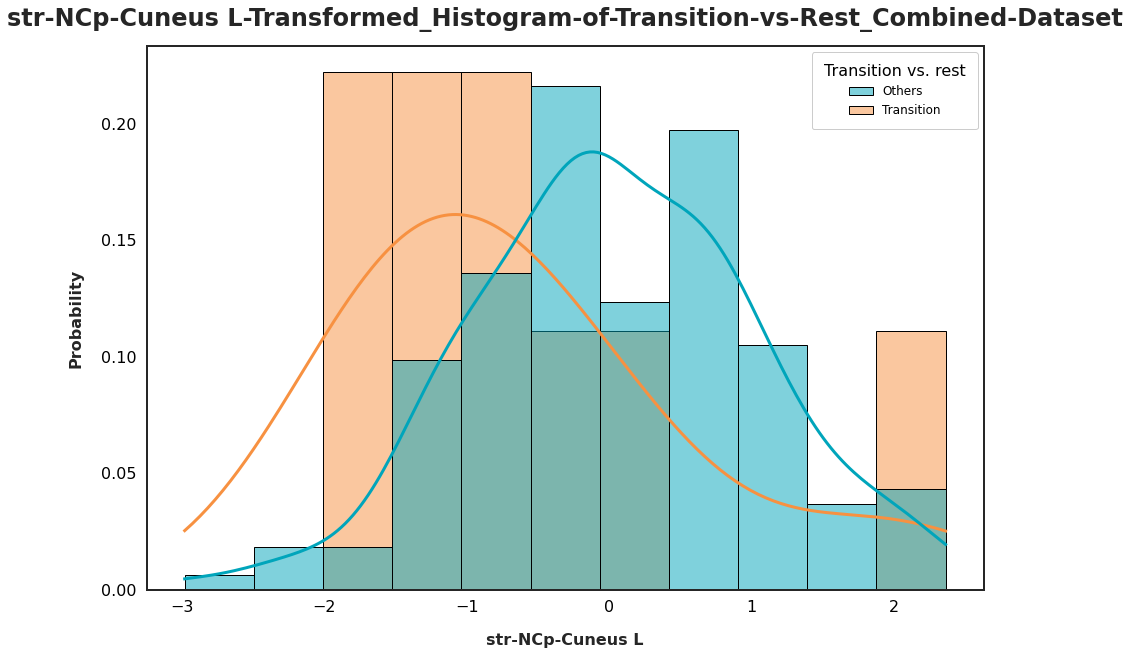

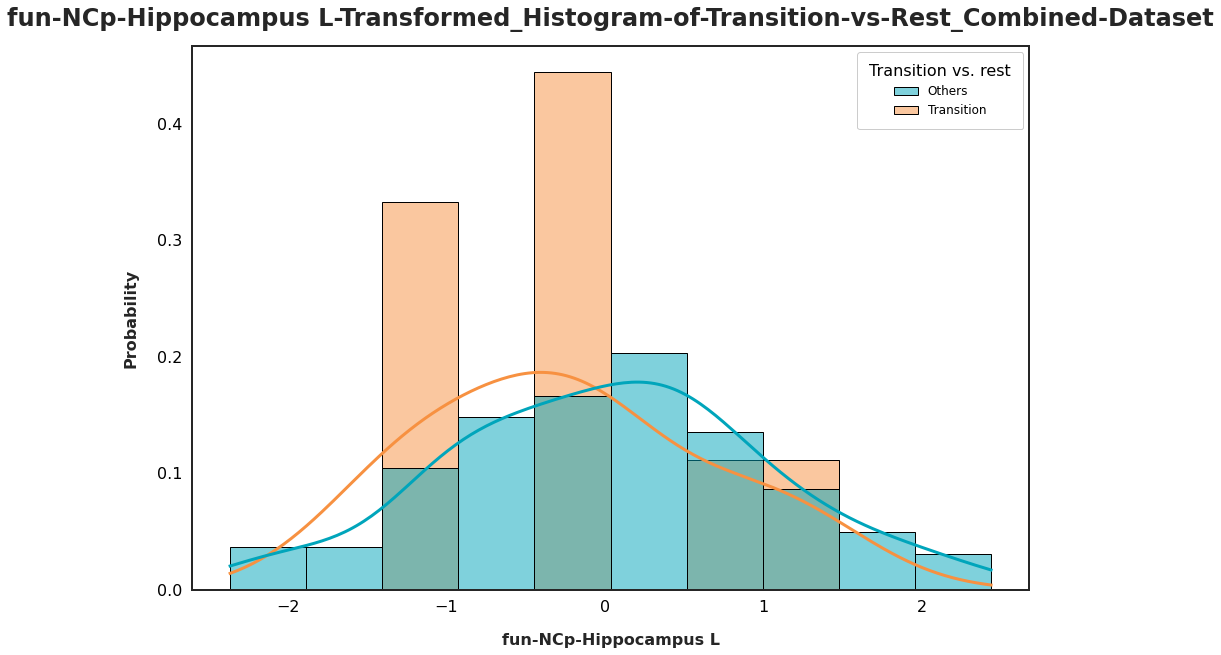

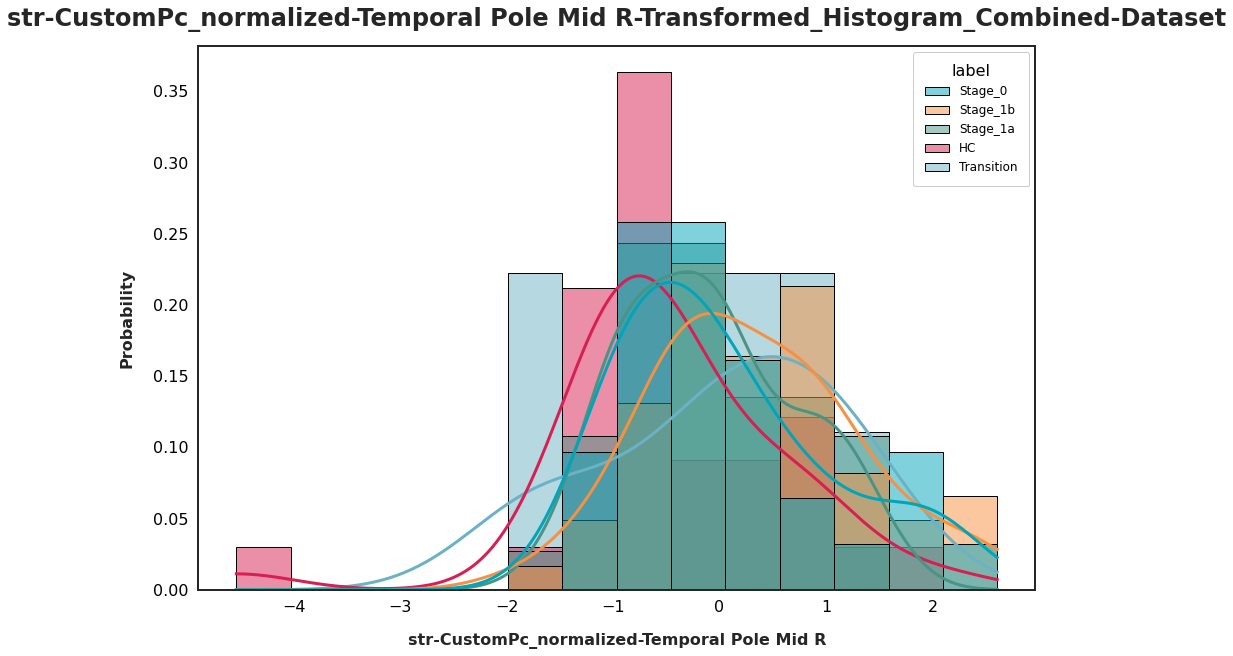

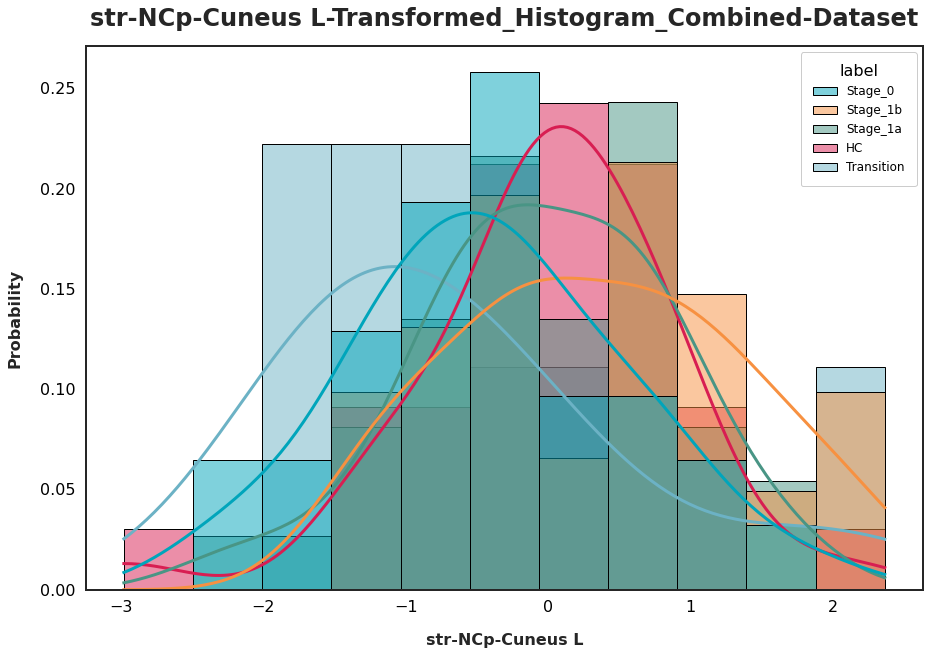

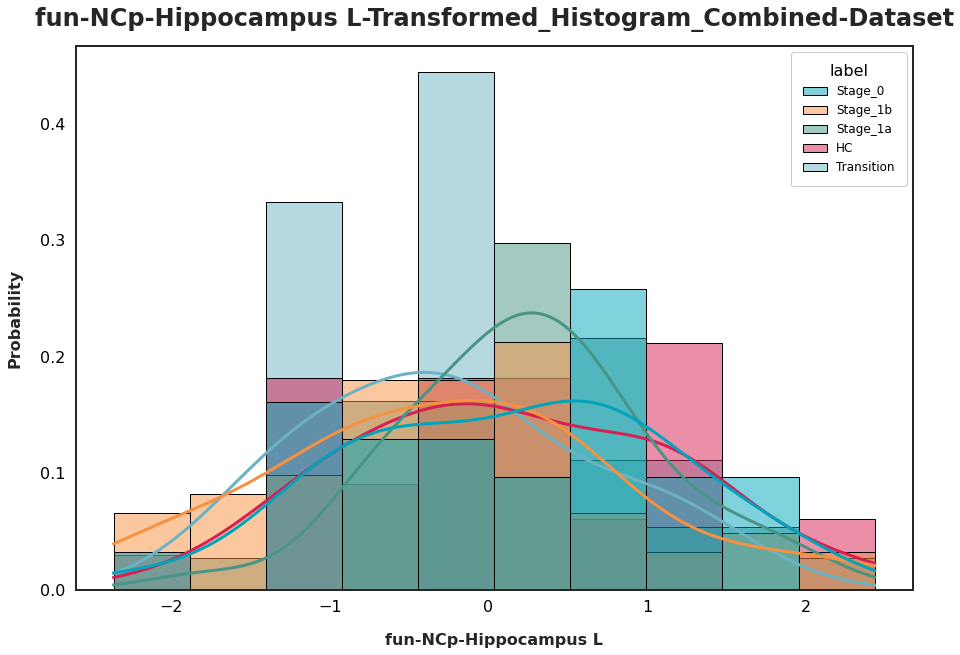

In [ ]:
# EDA after preprocessing
from sklearn.pipeline  import Pipeline
from sklearn.preprocessing import PowerTransformer, StandardScaler

if __name__ == "__main__": 
  df = pd.read_csv("./drive/MyDrive/research/structural-connectivity/data/combined_datasets.csv")
  feature_importances_df = pd.read_csv("./drive/MyDrive/research/structural-connectivity/results/feature_importances.csv")

  pipe = Pipeline(steps=[
                       ("Standard_Scaler", StandardScaler()),
                       ("Power Transform", PowerTransformer()),
  ])

  top_features = feature_importances_df[:3]['Feature'].values.tolist()
  dist_plot_df = df.copy(deep=True)
  display(dist_plot_df[top_features])
  dist_plot_df[top_features]=pipe.fit_transform(dist_plot_df[top_features])
  display(dist_plot_df[top_features])

  label_dict = {}
  for label in dist_plot_df.label.unique(): 
        label_dict[label] = get_label_ids(df, label)

  for label in label_dict:
      for feature in top_features:
          sample_name = f"{label}"
          fig_title = f"{feature}-Transformed_Histogram-of-{label}-vs-Rest_Combined-Dataset"
          fig = generate_feature_dist_plot(dist_plot_df, label_dict[label], feature, sample_name, hue_col=f"{label} vs. rest", title_string=fig_title, plot_path=ROOT_PLOT)

  for feature in top_features:
    fig_title = f"{feature}-Transformed_Histogram_Combined-Dataset"
    fig = generate_feature_dist_plot(dist_plot_df, [], feature, "", hue_col="label", title_string=fig_title, plot_path=ROOT_PLOT, one_vs_rest=False)

# END OF EDA

In [12]:
%%bash
pip install jupytext
cd drive/MyDrive/research/structural-connectivity
jupytext --to py EDA.ipynb

[jupytext] Reading EDA.ipynb in format ipynb
[jupytext] Writing EDA.py (destination file replaced [use --update to preserve cell outputs and ids])


In [ ]:
# # Experiment summary
# experiments = {
#     "Trial" :[1, 2, 3,
#              4, 5, 6,
#              7, 8, 9,
#               10, "11 - GBF"],
#     "Scaling": ['None', 'None', 'None',
#                 'Standard Scaler', 'Power Transform', 'None',
#                 'Standard Scaler', 'Power Transform', 'None',
#                 'None', 'None'],
#     "Features used" : ["All","UMAP","PCA",
#                        "All", 'All', '0.001 importance',
#                       '0.001 importance', '0.001 importance', '0.002 importance', 'Balanced Sample - All', "0.002 importance"],
#     "Num Features": [1356, 2, 2,
#                      1356, 1356, 190,
#                      190, 190, 12, 1356, 12],
#     'Accuracy': [0.2982456140350877, 0.22807017543859648, 0.2222222222222222,
#                  0.29239766081871343, 0.30409356725146197, 0.3508771929824561,
#                  0.3508771929824561, 0.34502923976608185, 0.38011695906432746,
#                  0.23809523809523808, 0.39766081871345027]
# }
# experiment_results = pd.DataFrame(experiments).sort_values(by='Accuracy', ascending=False)
# experiment_results.to_csv(f"{ROOT_RESULTS}experiment_results.csv", index=False)
# display(experiment_results)

,Trial,Scaling,Features used,Num Features,Accuracy
10,11 - GBF,None,0.002 importance,12,0.397661
8,9,None,0.002 importance,12,0.380117
5,6,None,0.001 importance,190,0.350877
6,7,Standard Scaler,0.001 importance,190,0.350877
7,8,Power Transform,0.001 importance,190,0.345029
4,5,Power Transform,All,1356,0.304094
0,1,None,All,1356,0.298246
3,4,Standard Scaler,All,1356,0.292398
9,10,None,Balanced Sample - All,1356,0.238095
1,2,None,UMAP,2,0.228070
